In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)

In [2]:
df = pd.read_excel("data/survey-data-tacr-dotaznik-pro-praktikujici-projektove-manazery.xlsx")
df_students = pd.read_excel("data/survey-data-tacr-dotaznik-pro-studenty-na-zacatku-kurzu.xlsx")

In [3]:
def plot_highest_and_lowest_avgs(df, top_10_description, bottom_10_description=None, hue_string=None, legend_title=None, filter_hue=None):
    if hue_string:
        column_means = df.drop(columns=[hue_string]).mean()
    else:
        column_means = df.mean()

    # Sort the means and select the top 10 and bottom 10 columns
    if hue_string is None:
        top_10_columns = column_means.nlargest(19).index.tolist()
        bottom_10_columns = column_means.nsmallest(19).iloc[::-1].index.tolist()
    else:
        value_counts = df[hue_string].value_counts()
        if len(value_counts) == 2:
            sorted_unique_hues = value_counts.index.tolist()
            df_ano = df[df[hue_string] == sorted_unique_hues[0]]
            df_ne = df[df[hue_string] == sorted_unique_hues[1]]
            mean_ano = df_ano.drop(columns=[hue_string]).mean()
            mean_ne = df_ne.drop(columns=[hue_string]).mean()
            diff_means = abs(mean_ano - mean_ne)
        else:
            group_means = df.groupby(hue_string).mean()
            column_variability = group_means.std()
            diff_means = column_variability.sort_values(ascending=False)
        top_10_columns = diff_means.nlargest(19).index.tolist()
        bottom_10_columns = diff_means.nsmallest(19).iloc[::-1].index.tolist()

    # Function to create a plot
    def create_barplot(columns, title):
        data_plot = df[columns]
        plt.figure(figsize=(15, 8))
        if hue_string is not None:
            if filter_hue is not None:
                data_plot = data_plot[data_plot[hue_string].isin(filter_hue)]
            data_plot = data_plot.melt(id_vars=hue_string, var_name='x', value_name='y')
            if filter_hue is not None:
                sns.barplot(data=data_plot, x="x", y="y", errorbar=None, hue=hue_string, hue_order=filter_hue)
            else:
                sns.barplot(data=data_plot, x="x", y="y", errorbar=None, hue=hue_string)
        else:
            data_plot = data_plot.melt(var_name='x', value_name='y')
            sns.barplot(data=data_plot, x="x", y="y", errorbar="sd", color="royalblue")
        plt.xticks(rotation=45)
        plt.title(title)
        plt.legend(loc='upper right', title=legend_title)
        plt.xlabel('')
        plt.ylabel('')
        plt.show()

    if hue_string is None:
        create_barplot(top_10_columns, top_10_description)
        create_barplot(bottom_10_columns, bottom_10_description)
    else:
        create_barplot(top_10_columns + [hue_string,], top_10_description)
        create_barplot(bottom_10_columns + [hue_string,], top_10_description)
    #create_barplot(top_10_variability_columns, '10 kompetencí s nejvyšší variabilitou využití')
    #create_barplot(bottom_10_variability_columns, '10 kompetencí s nejmenší variabilitou využití')

In [4]:
def plot_correlation(df):
    corr_mat = df.corr().stack().reset_index(name="correlation")
    g = sns.relplot(
        data=corr_mat,
        x="level_0", y="level_1", hue="correlation", size="correlation",
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 150), size_norm=(-.2, .8),
    )
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)

In [5]:
def plot_diff_avg(df_avg, column_1, column_2, title):
    data = df_avg
    # Determine the color based on whether column_1 is higher than column_2
    data['color'] = data.apply(lambda row: 'green' if row[column_1] > row[column_2] else 'red', axis=1)

    # Calculate the start point and length of each bar
    data['bar_start'] = data[[column_2, column_1]].min(axis=1)
    data['bar_end'] = data[[column_2, column_1]].max(axis=1) - data['bar_start']

    # Calculate the difference between column_2 and column_1 for sorting
    data['difference'] = abs(data[column_2] - data[column_1])

    # Sort data by the difference in descending order
    data_sorted = data.sort_values(by='difference', ascending=True)

    # Create a horizontal bar plot with the sorted data
    plt.figure(figsize=(10, 8))
    bars = plt.barh(data_sorted.index, data_sorted['bar_end'], left=data_sorted['bar_start'], color=data_sorted['color'])

    plt.grid(axis='y', which='major', color='gray', linestyle='--', linewidth=0.5)
    plt.title(title)
    plt.tight_layout()

    # Display the plot
    plt.show()

In [6]:
def update_column_names(df):
    column_name_mapping = {
        'Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu ': 'Specifikace požadavků',
        'Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) ': 'Architektura',
        'Stanovení kritérií úspěchu projektu a využití lessons learned z jiných projektů ': 'Kritéria úspěchu',
        'Stanovení termínového plánu projektu včetně odhadu pracnosti a doby trvání jednotlivých aktivit ': 'Termínový plán',
        'Monitorování, reportování a vyhodnocování průběhu projektu a přijímání nezbytných opatření ': 'Monitorování',
        "Monitorování, reportování a vyhodnocování průběhu projektu a příjímání nezbytných opatření ": 'Monitorování',
        'Posouzení, vyjednání a implementace změny projektu ': 'Změny',
        'Vytvoření a udržování systému finančního řízení a reportingu a monitorování stavu projektových financí ': 'Finanční řízení',
        'Odhad (a kalkulace) nákladů projektu včetně vytvoření rozpočtu ': 'Náklady a rozpočet',
        'Zajištění finančních zdrojů projektu ': 'Finanční zdroje',
        'Definice výstupů a pracovních balíků projektu, sestavení jejich hierarchie ': 'Pracovní balíky',
        'Monitorování rozsahu projektu a zabránení nepožadovanému překročení rozsahu projektu ': 'Rozsah',
        'Identifikace a analýza rizik a příležitostí a posouzení jejich pravděpodobnosti výskytu a dopad na projekt ': 'Analýza rizik',
        'Zpracování a implementace postupu pro řízení rizik ': 'Řízení rizik',
        'Monitorování a vyhodnocování rizik, příležitostí a implementace opatření ': 'Vyhodnocení rizik',
        'Naplánování, organizace a ověření dosažení cílů kvality projektu a doporučení nezbytných nápravných a/nebo preventivních opatření ': 'Kvalita',
        'Zajištění souladu projektu s prostředím a procesy podniku ': 'Soulad s podnikem',
        'Identifikace problémů, jejich příčin a vlivu na projekt, návrh a volba vhodných řešení ': 'Ident. problémů',
        'Kontrola a vyhodnocení implementovaných řešení problémů ': 'Kontrola řešení',
        'Definování struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ': 'Struktura řízení',
        'Stanovení nástrojů, procesů a systémů pro řízení projektu a předávání informací ': 'Nástroje a procesy',
        'Volba a efektivní ovládání software pro řízení projektu včetně informačních toků ': 'Software',
        'Sestavení projektového týmu, podpora spolupráce a budování vztahů mezi členy týmu ': 'Týmová spolupráce',
        'Posilování týmu delegováním úkolů, odpovědností a učením se z chyb ': 'Delegování',
        'Definice množství požadovaných zdrojů, sestavení plánu zdrojů pro realizaci a dodání projektu ': 'Plán zdrojů',
        'Identifikace potenciálních poskytovatelů zdrojů a vyjednávání o jejich poskytnutí ': 'Poskytovatelé zdrojů',
        'Alokace a distribuce zdrojů podle definované potřeby, vyhodnocení jejich využití a provedení případných nápravných opatření ': 'Alokace zdrojů',
        'Určení, ohodnocení a přezkoumání KPI (klíčové ukazatele výkonnosti) projektu a kritické faktory jeho úspěchu ': 'KPI a úspěch',
        'Aplikace analytických a kreativních technik (např. kritické a koncepční myšlení, stanovení priorit, brainstorming aj.) na analýzu situací, finančních a organizačních dat a trendů ': 'Analýza a techniky',
        'Volba komunikačního stylu a kanálů s ohledem na potřeby publika a situace, poskytování jasných a strukturovaných informací a ověřování porozumění ': 'Komunikace',
        'Aktivní naslouchání a podpora otevřené komunikace ': 'Naslouchání',
        'Zajištění efektivní komunikace s virtuálními týmy ': 'Virtuální týmy',
        'Znalost základů pracovního práva (např. zákoník práce, zákon o zadávání veřejných zakázek) ': 'Pracovní právo',
        'Identifikace zainteresovaných stran (stakeholderů), analýza jejich zájmu a vlivu a udržování dobrých vztahů ': 'Stakeholdeři',
        'Rozhodování a prosazování rozhodnutí a přijímání odpovědnosti ': 'Rozhodování',
        "Rozhodování a prosazování rozhodnutí a příjmání odpovědnosti ": "Rozhodování",
        'Předvídání a předcházení konfliktům a krizím ': 'Konflikty a krize',
        'Dohlížení na plnění objednávek a smluv, řešení problémů a v případě potřeby vyhledávání nápravy ': 'Objednávky a smlouvy',
        'Posouzení charakteru a hodnoty kulturního prostředí a jejich důsledků pro projekt ': 'Kulturní prostředí',
        'Organizace vlastní práce dle situace a vlastních zdrojů ': 'Sebeorganizace',
        "Definice struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ": "Definice rolí",
    }
    df = df.rename(columns=column_name_mapping)
    return df

In [7]:
column_name_mapping = {
    'Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu ': 'Specifikace požadavků',
    'Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) ': 'Architektura',
    'Stanovení kritérií úspěchu projektu a využití lessons learned z jiných projektů ': 'Kritéria úspěchu',
    'Stanovení termínového plánu projektu včetně odhadu pracnosti a doby trvání jednotlivých aktivit ': 'Termínový plán',
    'Monitorování, reportování a vyhodnocování průběhu projektu a přijímání nezbytných opatření ': 'Monitorování',
    "Monitorování, reportování a vyhodnocování průběhu projektu a příjímání nezbytných opatření ": 'Monitorování',
    'Posouzení, vyjednání a implementace změny projektu ': 'Změny',
    'Vytvoření a udržování systému finančního řízení a reportingu a monitorování stavu projektových financí ': 'Finanční řízení',
    'Odhad (a kalkulace) nákladů projektu včetně vytvoření rozpočtu ': 'Náklady a rozpočet',
    'Zajištění finančních zdrojů projektu ': 'Finanční zdroje',
    'Definice výstupů a pracovních balíků projektu, sestavení jejich hierarchie ': 'Pracovní balíky',
    'Monitorování rozsahu projektu a zabránení nepožadovanému překročení rozsahu projektu ': 'Rozsah',
    'Identifikace a analýza rizik a příležitostí a posouzení jejich pravděpodobnosti výskytu a dopad na projekt ': 'Analýza rizik',
    'Zpracování a implementace postupu pro řízení rizik ': 'Řízení rizik',
    'Monitorování a vyhodnocování rizik, příležitostí a implementace opatření ': 'Vyhodnocení rizik',
    'Naplánování, organizace a ověření dosažení cílů kvality projektu a doporučení nezbytných nápravných a/nebo preventivních opatření ': 'Kvalita',
    'Zajištění souladu projektu s prostředím a procesy podniku ': 'Soulad s podnikem',
    'Identifikace problémů, jejich příčin a vlivu na projekt, návrh a volba vhodných řešení ': 'Ident. problémů',
    'Kontrola a vyhodnocení implementovaných řešení problémů ': 'Kontrola řešení',
    'Definování struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ': 'Struktura řízení',
    'Stanovení nástrojů, procesů a systémů pro řízení projektu a předávání informací ': 'Nástroje a procesy',
    'Volba a efektivní ovládání software pro řízení projektu včetně informačních toků ': 'Software',
    'Sestavení projektového týmu, podpora spolupráce a budování vztahů mezi členy týmu ': 'Týmová spolupráce',
    'Posilování týmu delegováním úkolů, odpovědností a učením se z chyb ': 'Delegování',
    'Definice množství požadovaných zdrojů, sestavení plánu zdrojů pro realizaci a dodání projektu ': 'Plán zdrojů',
    'Identifikace potenciálních poskytovatelů zdrojů a vyjednávání o jejich poskytnutí ': 'Poskytovatelé zdrojů',
    'Alokace a distribuce zdrojů podle definované potřeby, vyhodnocení jejich využití a provedení případných nápravných opatření ': 'Alokace zdrojů',
    'Určení, ohodnocení a přezkoumání KPI (klíčové ukazatele výkonnosti) projektu a kritické faktory jeho úspěchu ': 'KPI a úspěch',
    'Aplikace analytických a kreativních technik (např. kritické a koncepční myšlení, stanovení priorit, brainstorming aj.) na analýzu situací, finančních a organizačních dat a trendů ': 'Analýza a techniky',
    'Volba komunikačního stylu a kanálů s ohledem na potřeby publika a situace, poskytování jasných a strukturovaných informací a ověřování porozumění ': 'Komunikace',
    'Aktivní naslouchání a podpora otevřené komunikace ': 'Naslouchání',
    'Zajištění efektivní komunikace s virtuálními týmy ': 'Virtuální týmy',
    'Znalost základů pracovního práva (např. zákoník práce, zákon o zadávání veřejných zakázek) ': 'Pracovní právo',
    'Identifikace zainteresovaných stran (stakeholderů), analýza jejich zájmu a vlivu a udržování dobrých vztahů ': 'Stakeholdeři',
    'Rozhodování a prosazování rozhodnutí a přijímání odpovědnosti ': 'Rozhodování',
    "Rozhodování a prosazování rozhodnutí a příjmání odpovědnosti ": "Rozhodování",
    'Předvídání a předcházení konfliktům a krizím ': 'Konflikty a krize',
    'Dohlížení na plnění objednávek a smluv, řešení problémů a v případě potřeby vyhledávání nápravy ': 'Objednávky a smlouvy',
    'Posouzení charakteru a hodnoty kulturního prostředí a jejich důsledků pro projekt ': 'Kulturní prostředí',
    'Organizace vlastní práce dle situace a vlastních zdrojů ': 'Sebeorganizace',
    "Definice struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ": "Definice rolí",
}

column_group_mapping = {
    'Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu ': 'Requirements and objectives',
    'Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) ': 'Project design',
    'Stanovení kritérií úspěchu projektu a využití lessons learned z jiných projektů ': 'Project design',
    'Stanovení termínového plánu projektu včetně odhadu pracnosti a doby trvání jednotlivých aktivit ': ' Time',
    'Monitorování, reportování a vyhodnocování průběhu projektu a přijímání nezbytných opatření ': 'Plan and control the project execution',
    "Monitorování, reportování a vyhodnocování průběhu projektu a příjímání nezbytných opatření ": 'Plan and control the project execution',
    'Posouzení, vyjednání a implementace změny projektu ': 'Plan and control the project execution',
    'Vytvoření a udržování systému finančního řízení a reportingu a monitorování stavu projektových financí ': 'Finance',
    'Odhad (a kalkulace) nákladů projektu včetně vytvoření rozpočtu ': 'Finance',
    'Zajištění finančních zdrojů projektu ': 'Finance',
    'Definice výstupů a pracovních balíků projektu, sestavení jejich hierarchie ': 'Scope',
    'Monitorování rozsahu projektu a zabránení nepožadovanému překročení rozsahu projektu ': 'Scope',
    'Identifikace a analýza rizik a příležitostí a posouzení jejich pravděpodobnosti výskytu a dopad na projekt ': 'Risk and opportunity',
    'Zpracování a implementace postupu pro řízení rizik ': 'Risk and opportunity',
    'Monitorování a vyhodnocování rizik, příležitostí a implementace opatření ': 'Risk and opportunity',
    'Naplánování, organizace a ověření dosažení cílů kvality projektu a doporučení nezbytných nápravných a/nebo preventivních opatření ': 'Quality',
    'Zajištění souladu projektu s prostředím a procesy podniku ': 'Governance, structures and processes',
    'Identifikace problémů, jejich příčin a vlivu na projekt, návrh a volba vhodných řešení ': 'Problem solving',
    'Kontrola a vyhodnocení implementovaných řešení problémů ': 'Problem solving',
    'Definování struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ': 'Organisation and information',
    'Stanovení nástrojů, procesů a systémů pro řízení projektu a předávání informací ': 'Organisation and information',
    'Volba a efektivní ovládání software pro řízení projektu včetně informačních toků ': 'Organisation and information',
    'Sestavení projektového týmu, podpora spolupráce a budování vztahů mezi členy týmu ': 'Teamwork',
    'Posilování týmu delegováním úkolů, odpovědností a učením se z chyb ': 'Teamwork',
    'Definice množství požadovaných zdrojů, sestavení plánu zdrojů pro realizaci a dodání projektu ': 'Resources',
    'Identifikace potenciálních poskytovatelů zdrojů a vyjednávání o jejich poskytnutí ': 'Resources',
    'Alokace a distribuce zdrojů podle definované potřeby, vyhodnocení jejich využití a provedení případných nápravných opatření ': 'Resources',
    'Určení, ohodnocení a přezkoumání KPI (klíčové ukazatele výkonnosti) projektu a kritické faktory jeho úspěchu ': 'Strategy',
    'Aplikace analytických a kreativních technik (např. kritické a koncepční myšlení, stanovení priorit, brainstorming aj.) na analýzu situací, finančních a organizačních dat a trendů ': 'Resourcefulness',
    'Volba komunikačního stylu a kanálů s ohledem na potřeby publika a situace, poskytování jasných a strukturovaných informací a ověřování porozumění ': 'Personal communication',
    'Aktivní naslouchání a podpora otevřené komunikace ': 'Personal communication',
    'Zajištění efektivní komunikace s virtuálními týmy ': 'Personal communication',
    'Znalost základů pracovního práva (např. zákoník práce, zákon o zadávání veřejných zakázek) ': 'Compliance, standards and regulations',
    'Identifikace zainteresovaných stran (stakeholderů), analýza jejich zájmu a vlivu a udržování dobrých vztahů ': 'Stakeholders',
    'Rozhodování a prosazování rozhodnutí a přijímání odpovědnosti ': 'Leadership',
    "Rozhodování a prosazování rozhodnutí a příjmání odpovědnosti ": "Leadership",
    'Předvídání a předcházení konfliktům a krizím ': 'Conflict and crisis',
    'Dohlížení na plnění objednávek a smluv, řešení problémů a v případě potřeby vyhledávání nápravy ': 'Procurement',
    'Posouzení charakteru a hodnoty kulturního prostředí a jejich důsledků pro projekt ': 'Relationships and engagements',
    'Organizace vlastní práce dle situace a vlastních zdrojů ': 'Self-reflection and self-management',
    "Definice struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ": "Teamwork",
}

In [8]:
def count_plot(df, title, y):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y=y)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")


In [9]:
def hue_plot_usage(df_filtered, search_string, title, hue_string=None, legend_title=None, filter_hue=None):    
    filtered_columns = [col for col in df_filtered.columns if search_string in col]
    if hue_string:
        filtered_columns += [hue_string, ]
    df_filtered = df_filtered[filtered_columns]
    df_filtered = df_filtered.rename(columns=lambda x: x.replace(search_string, ""))
    df_filtered = update_column_names(df_filtered)
    if hue_string:
        plot_highest_and_lowest_avgs(df_filtered, title, hue_string=hue_string, legend_title=legend_title, filter_hue=filter_hue)
    else:
        plot_highest_and_lowest_avgs(df_filtered, title)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


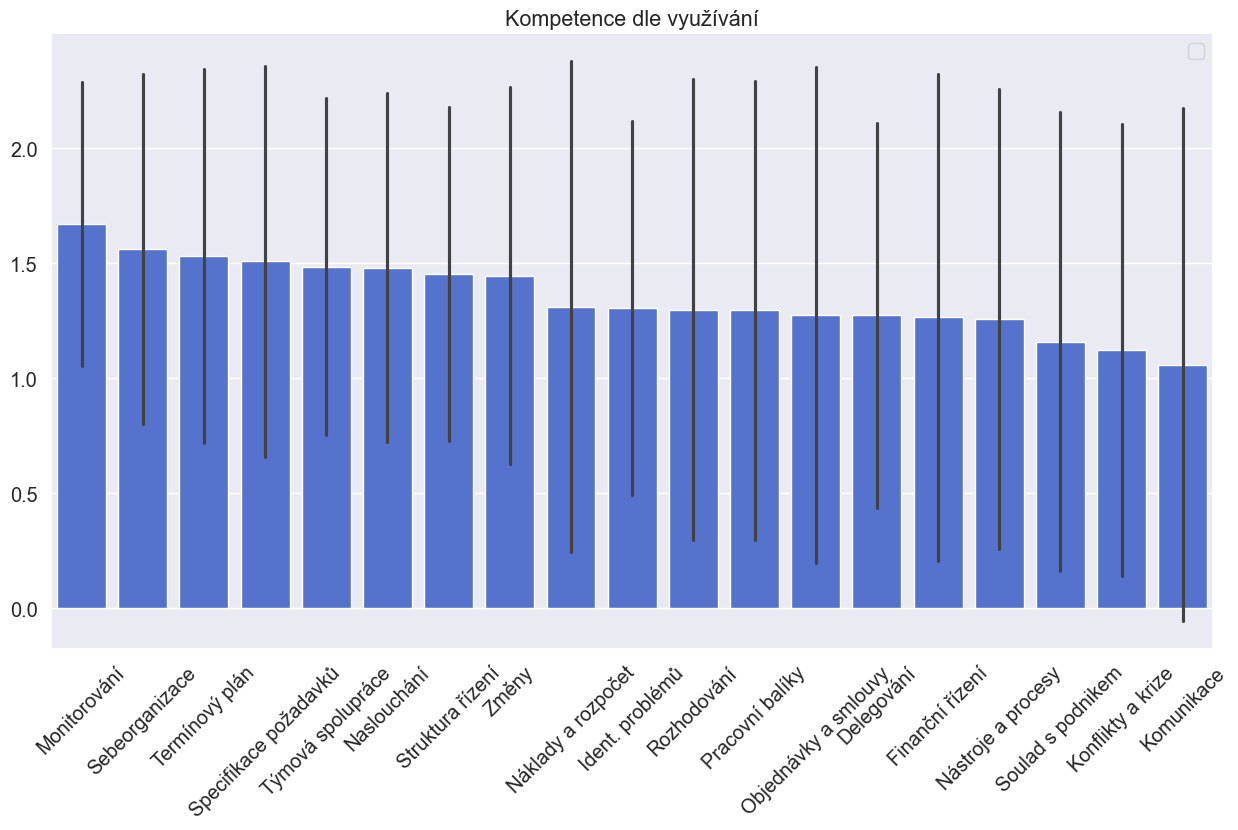

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


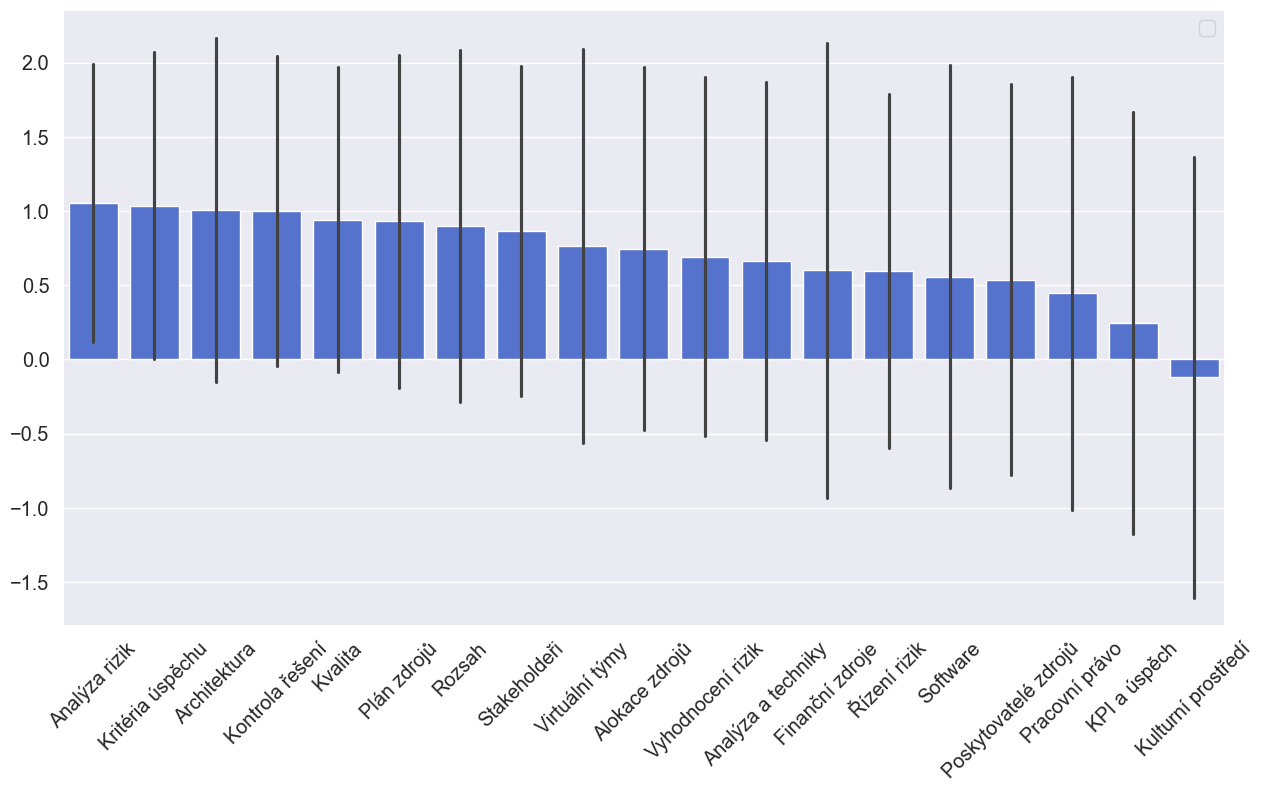

In [10]:
search_string = "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně"

filtered_columns = [col for col in df.columns if search_string in col]
df_filtered_usage = df[filtered_columns]
df_filtered_usage = df_filtered_usage.rename(columns=lambda x: x.replace(search_string, ""))
df_filtered_usage = update_column_names(df_filtered_usage)

hue_plot_usage(df, search_string, 'Kompetence dle využívání')

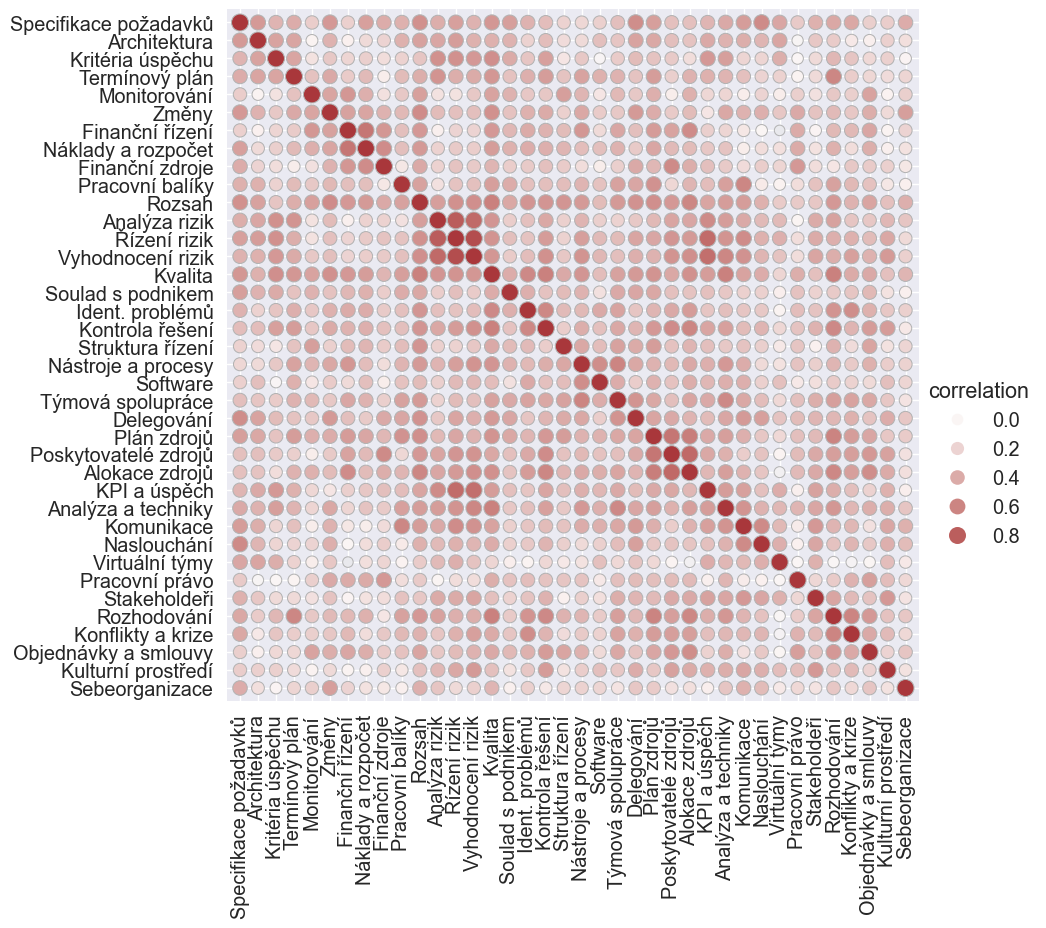

In [11]:
plot_correlation(df_filtered_usage)

In [12]:
df_avg = df_filtered_usage.mean().to_frame(name="Využití")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


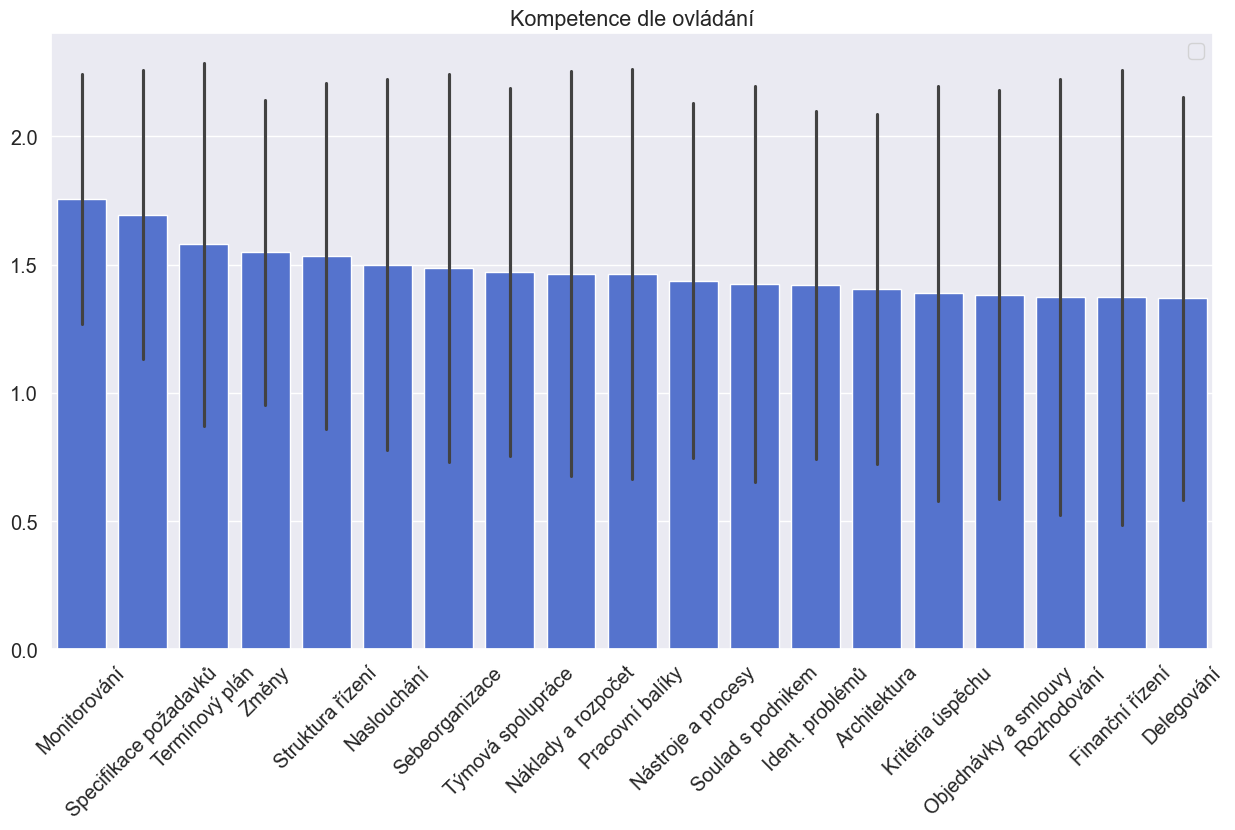

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


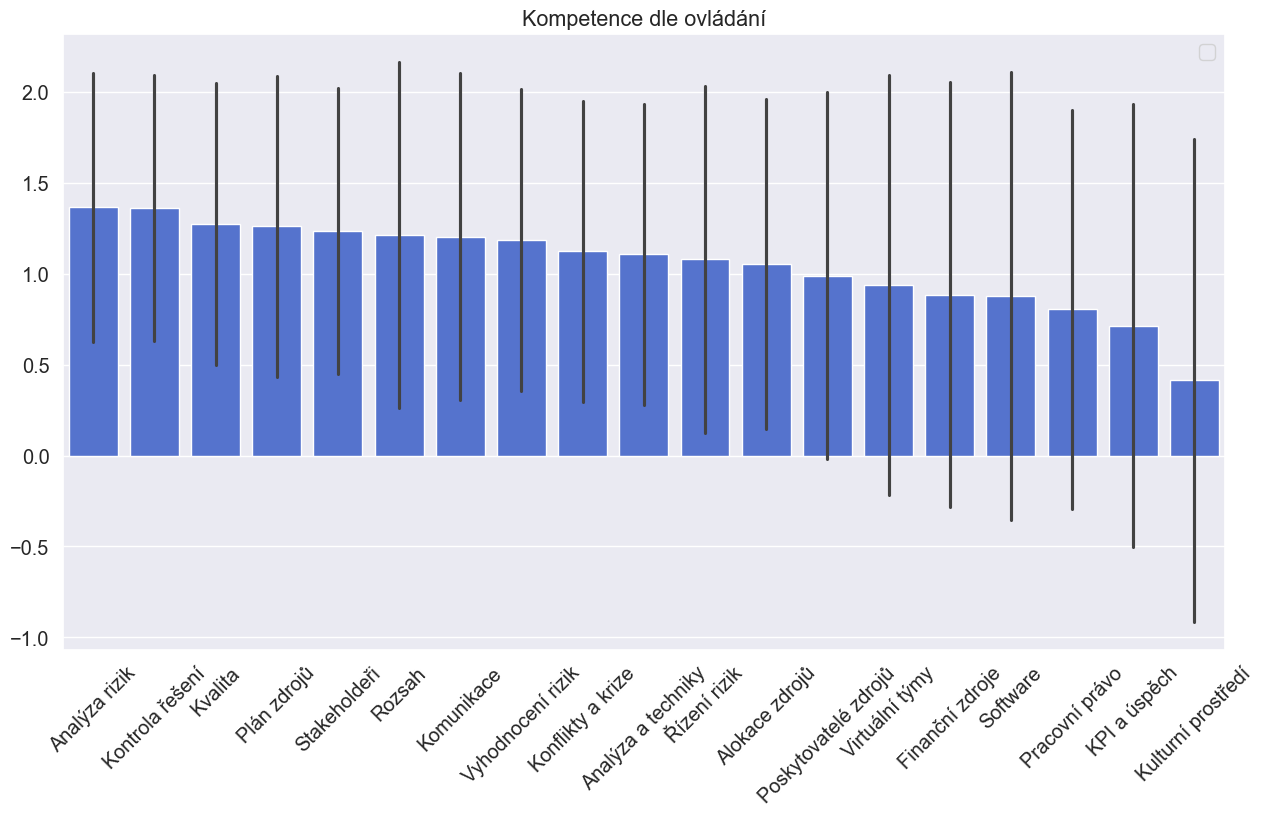

In [13]:
search_string = "x vůbec neovládám x zcela ovládám"

filtered_columns = [col for col in df.columns if search_string in col]
df_filtered_mastering = df[filtered_columns]
df_filtered_mastering = df_filtered_mastering.rename(columns=lambda x: x.replace(search_string, ""))
df_filtered_mastering = update_column_names(df_filtered_mastering)
plot_highest_and_lowest_avgs(df_filtered_mastering, 'Kompetence dle ovládání', 'Kompetence dle ovládání')

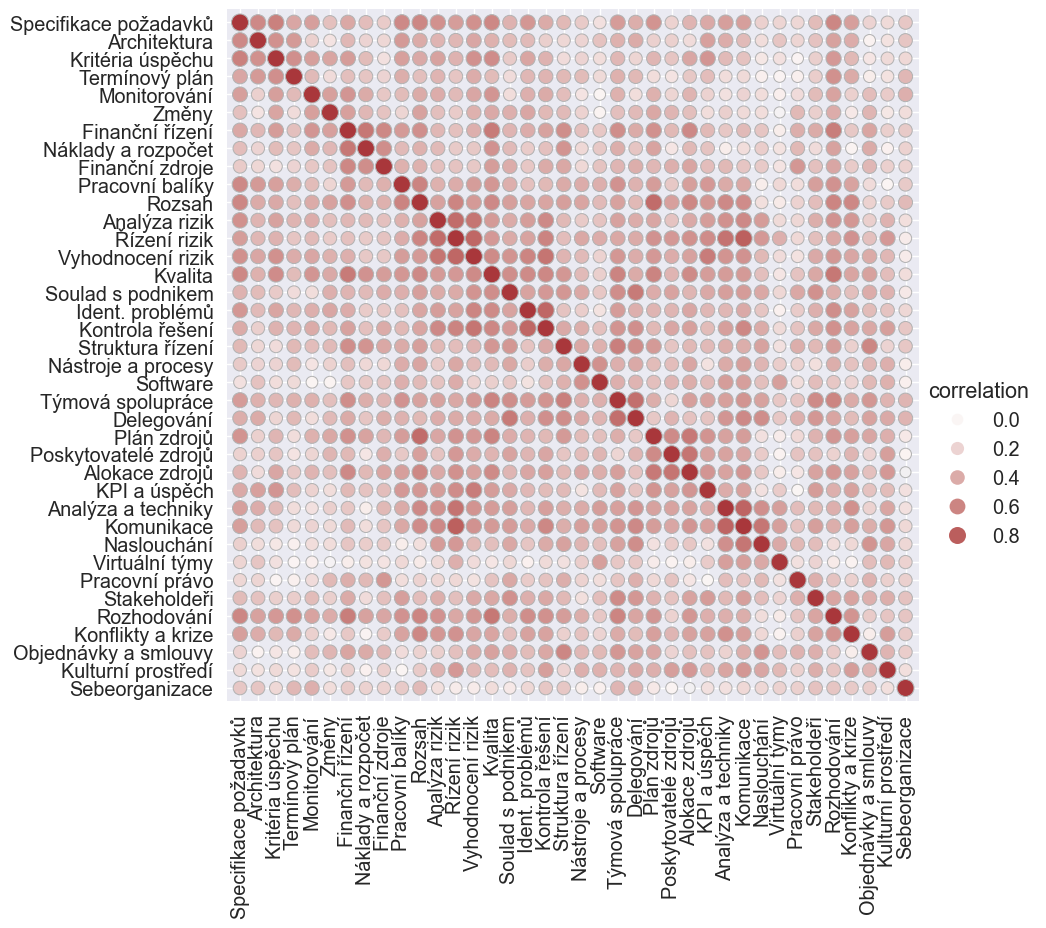

In [14]:
plot_correlation(df_filtered_mastering)

In [15]:
df_avg = pd.merge(df_avg, df_filtered_mastering.mean().to_frame(name="Ovládání"), left_index=True, right_index=True)

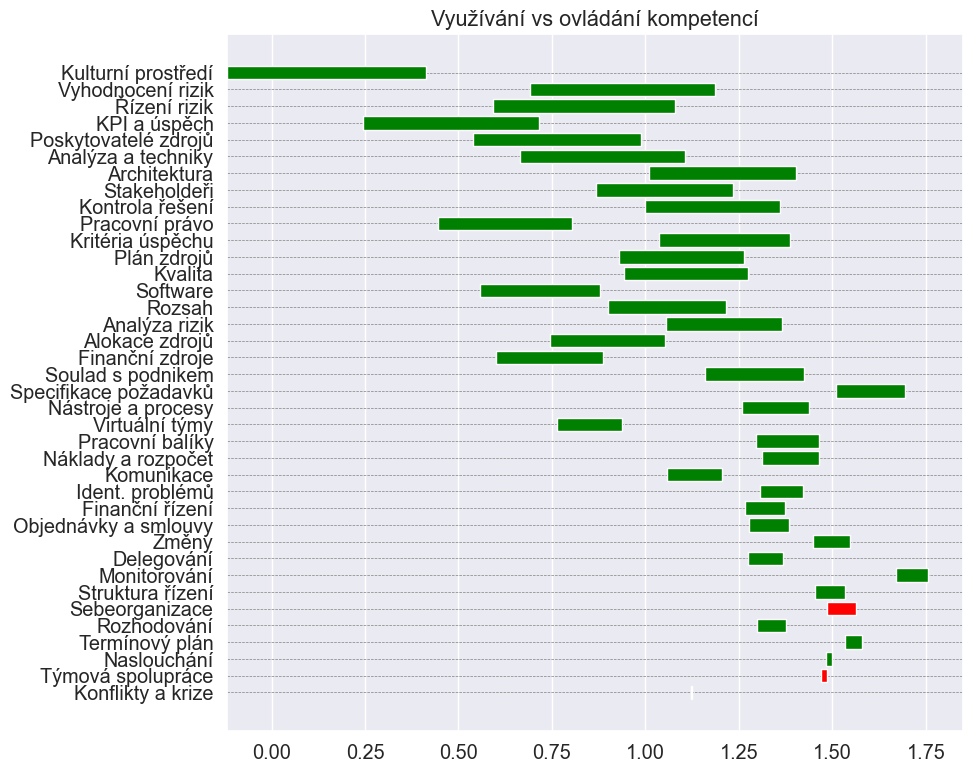

In [16]:
plot_diff_avg(df_avg, "Ovládání", "Využití", "Využívání vs ovládání kompetencí")

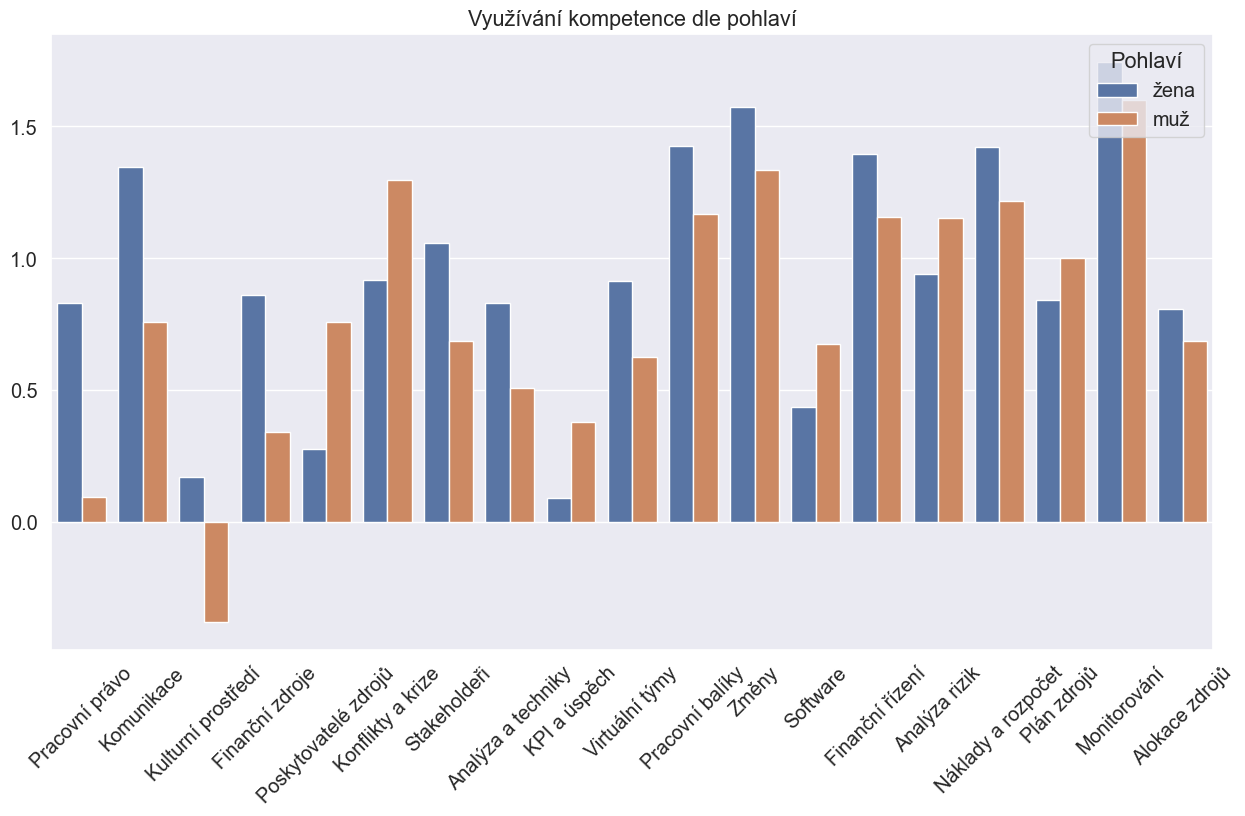

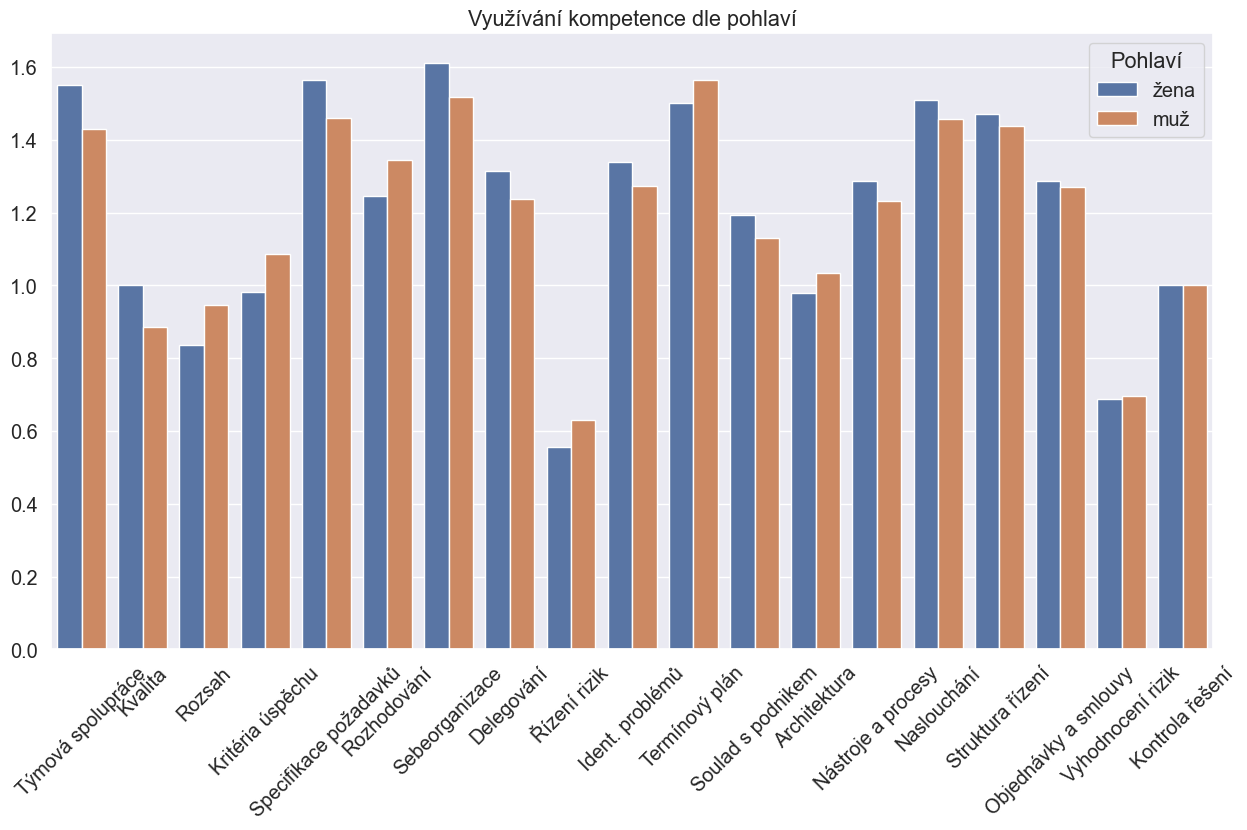

In [17]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 'Využívání kompetence dle pohlaví', "Jaké je vaše pohlaví?", "Pohlaví")

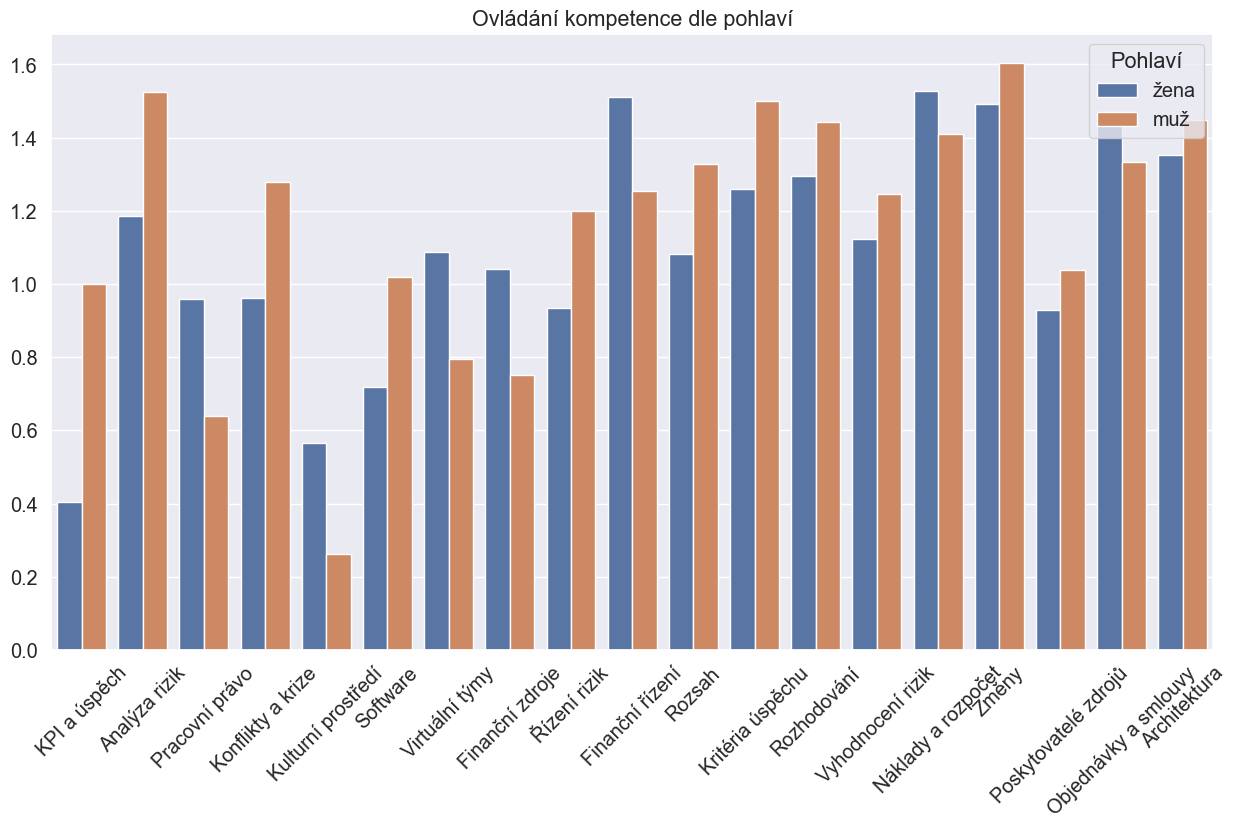

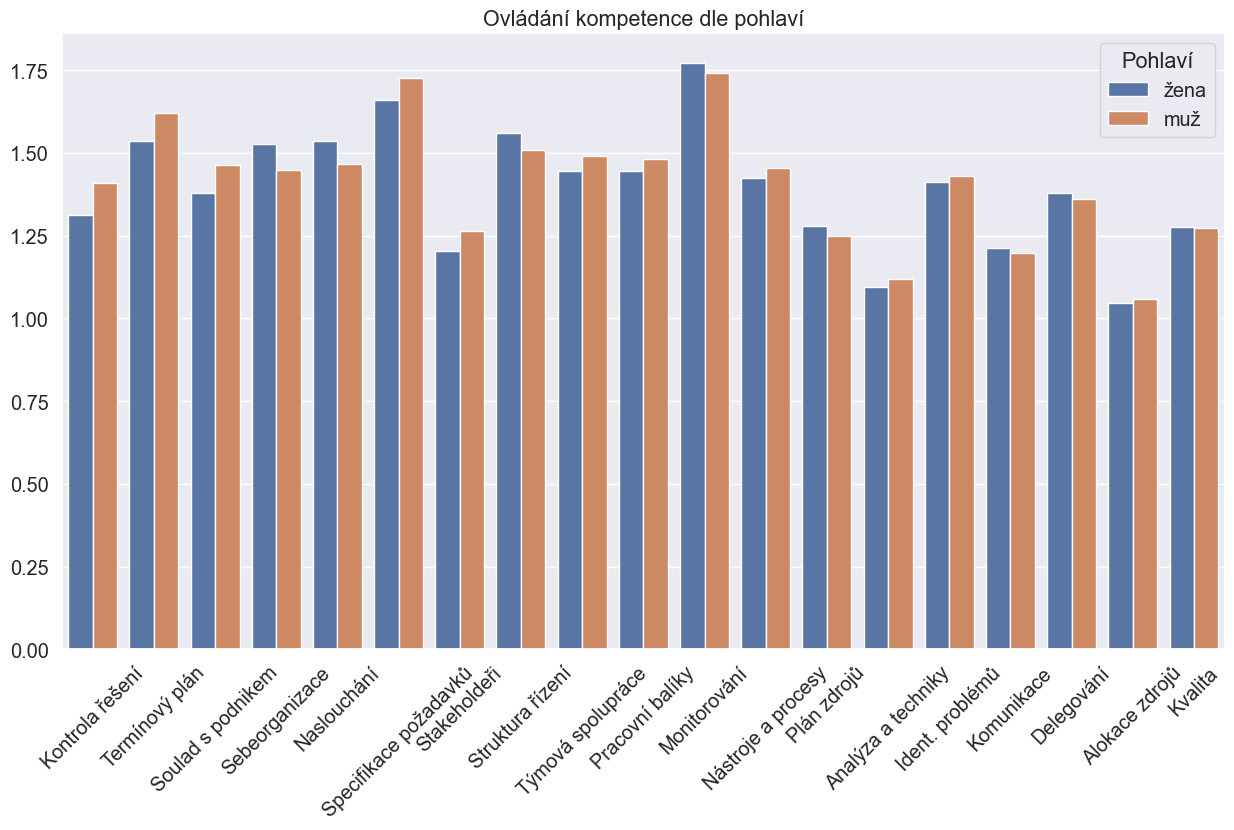

In [18]:
hue_plot_usage(df, "x vůbec neovládám x zcela ovládám", 'Ovládání kompetence dle pohlaví', "Jaké je vaše pohlaví?", "Pohlaví")

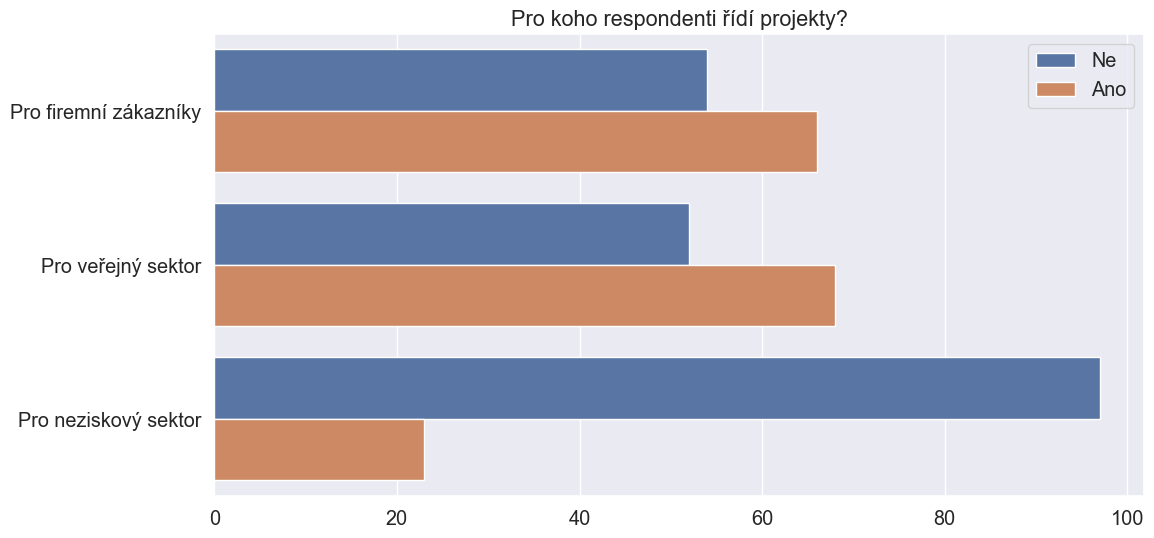

In [19]:
columns = [
    "Jaké typy projektu řídíte? x pro firemní zákazníky",
    "Jaké typy projektu řídíte? x pro veřejný sektor",
    "Jaké typy projektu řídíte? x pro neziskový sektor"
]

# Melt the DataFrame so we have 'Project Type' and 'Response' columns
melted_df = df[columns].melt(var_name='Project Type', value_name='Response')
melted_df["Project Type"] = melted_df["Project Type"].str.replace("Jaké typy projektu řídíte? x ", "").str.capitalize()

# Create the count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=melted_df, y='Project Type', hue='Response')

# Enhance plot aesthetics
plt.title("Pro koho respondenti řídí projekty?")
plt.xlabel("")
plt.ylabel("")
plt.legend()

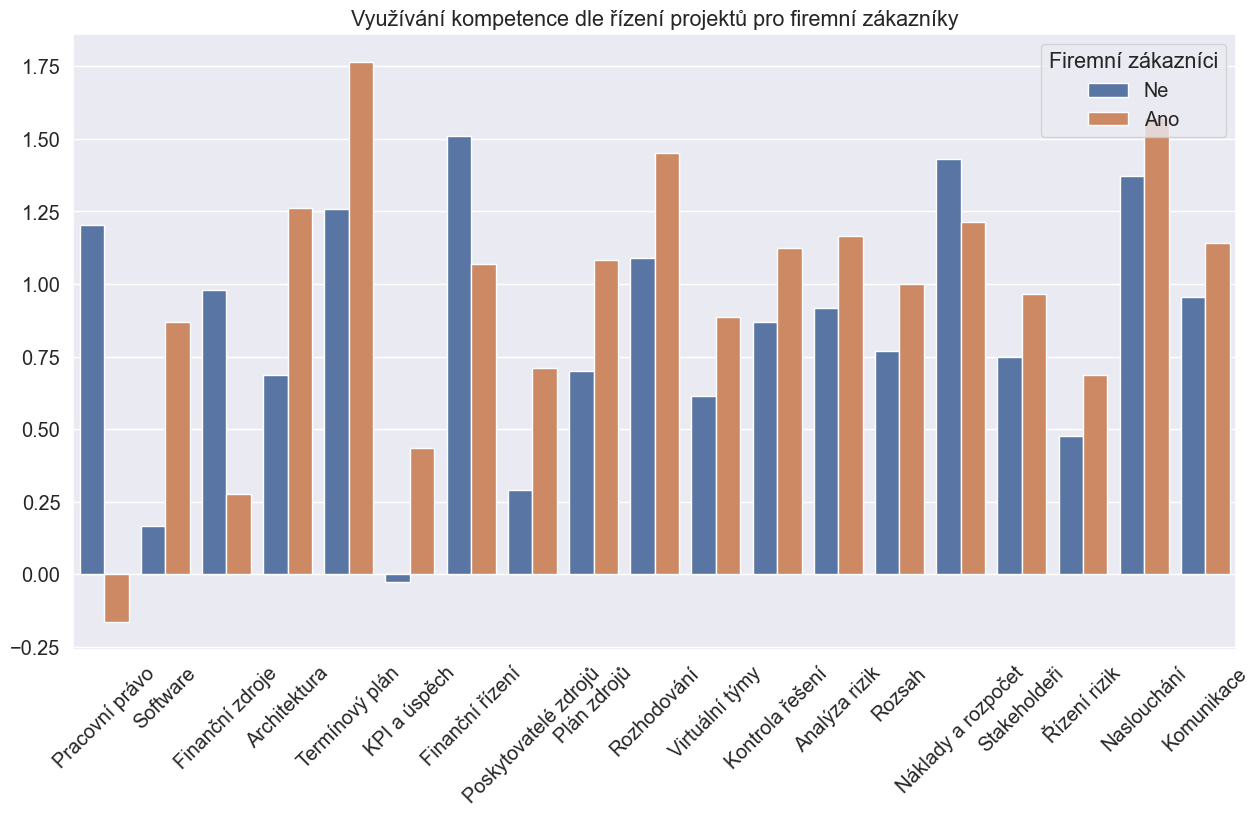

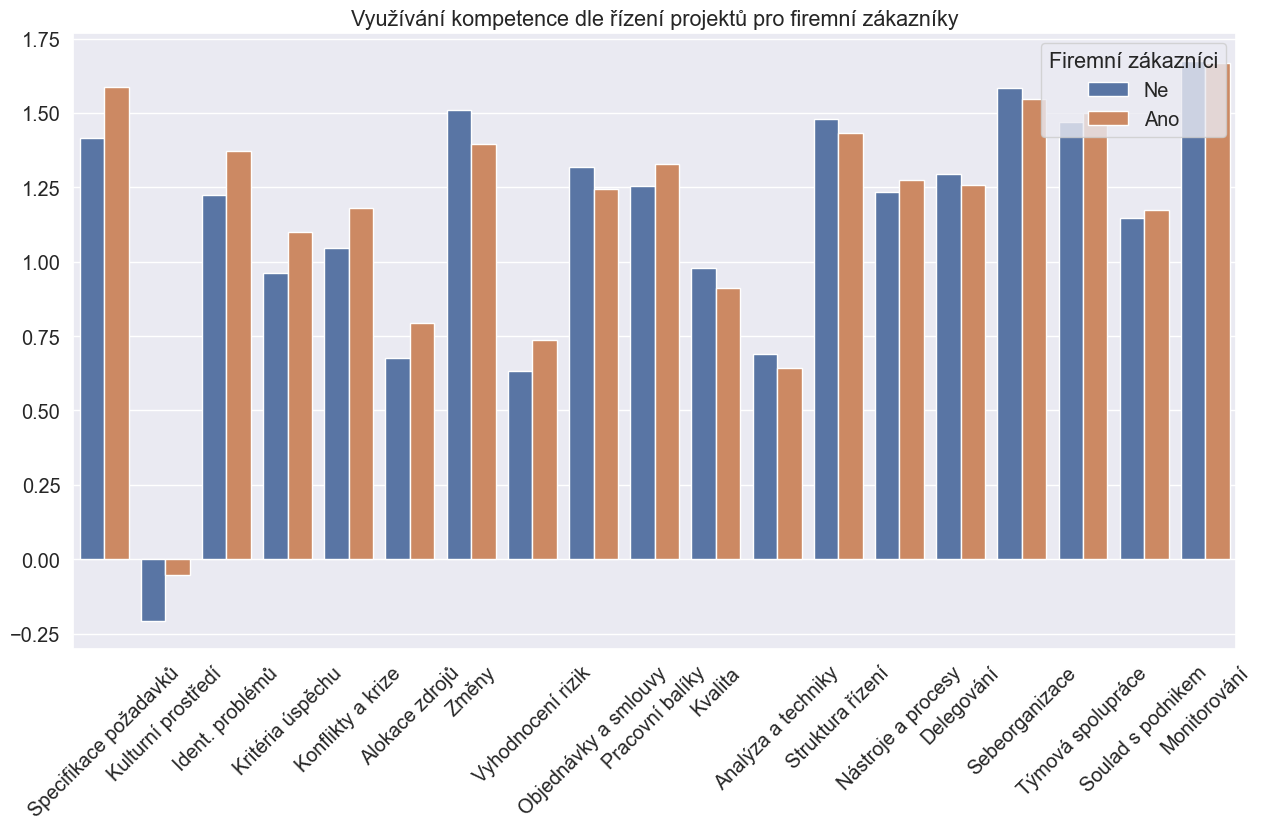

In [20]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 
               'Využívání kompetence dle řízení projektů pro firemní zákazníky', "Jaké typy projektu řídíte? x pro firemní zákazníky", "Firemní zákazníci")

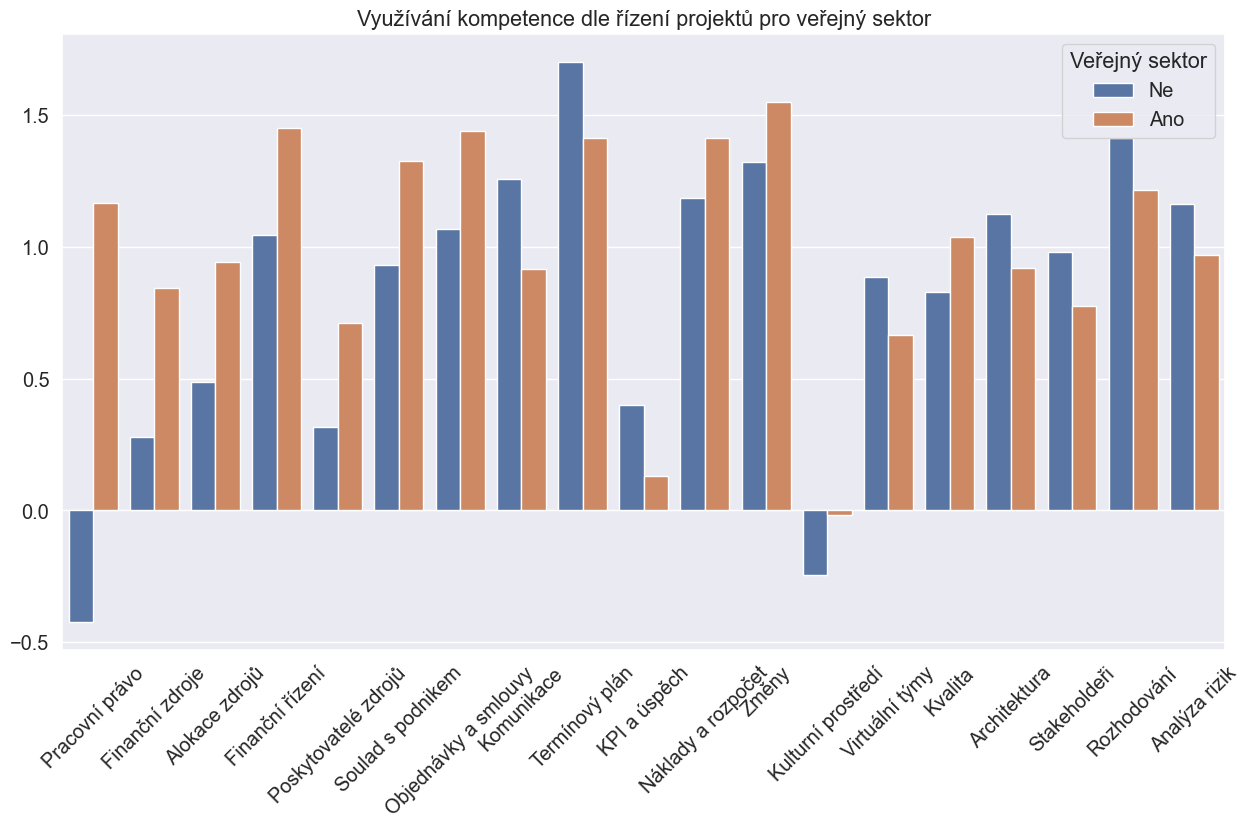

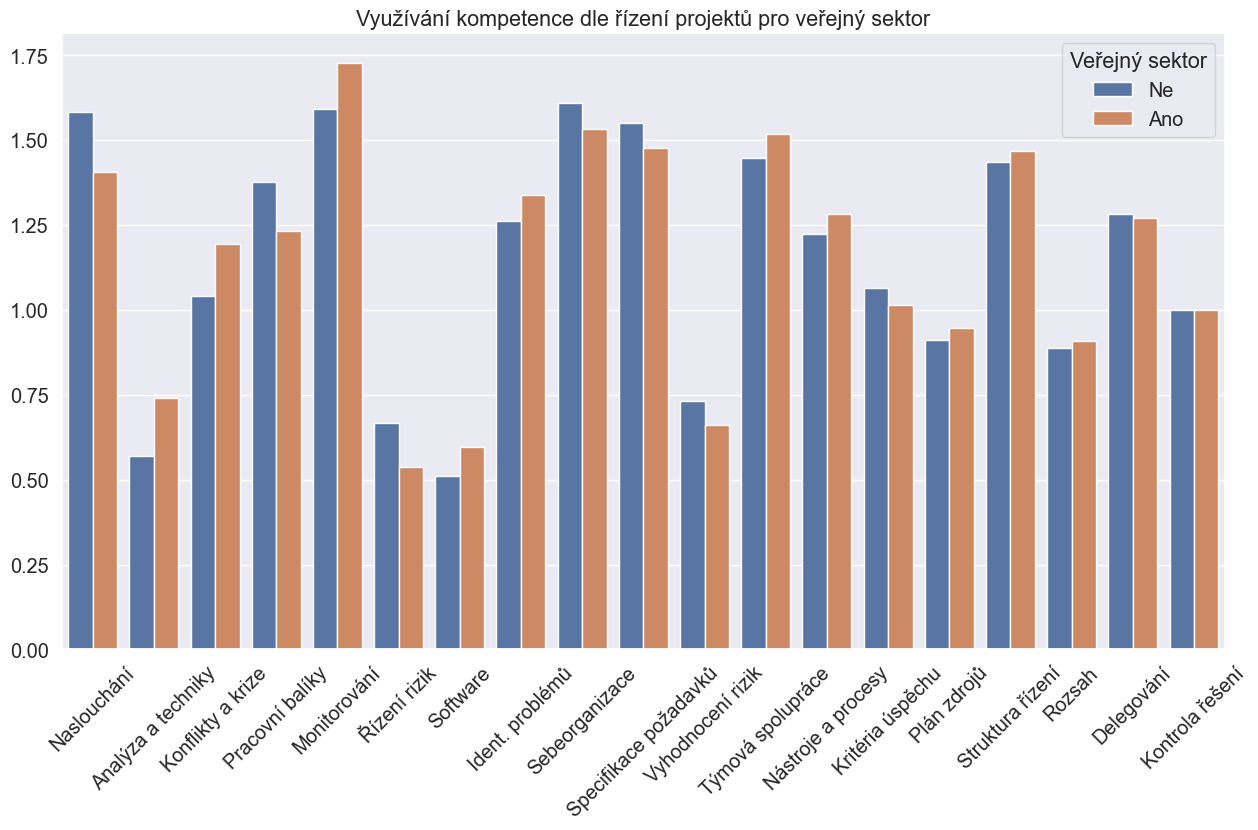

In [21]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 'Využívání kompetence dle řízení projektů pro veřejný sektor', 
               "Jaké typy projektu řídíte? x pro veřejný sektor", "Veřejný sektor")

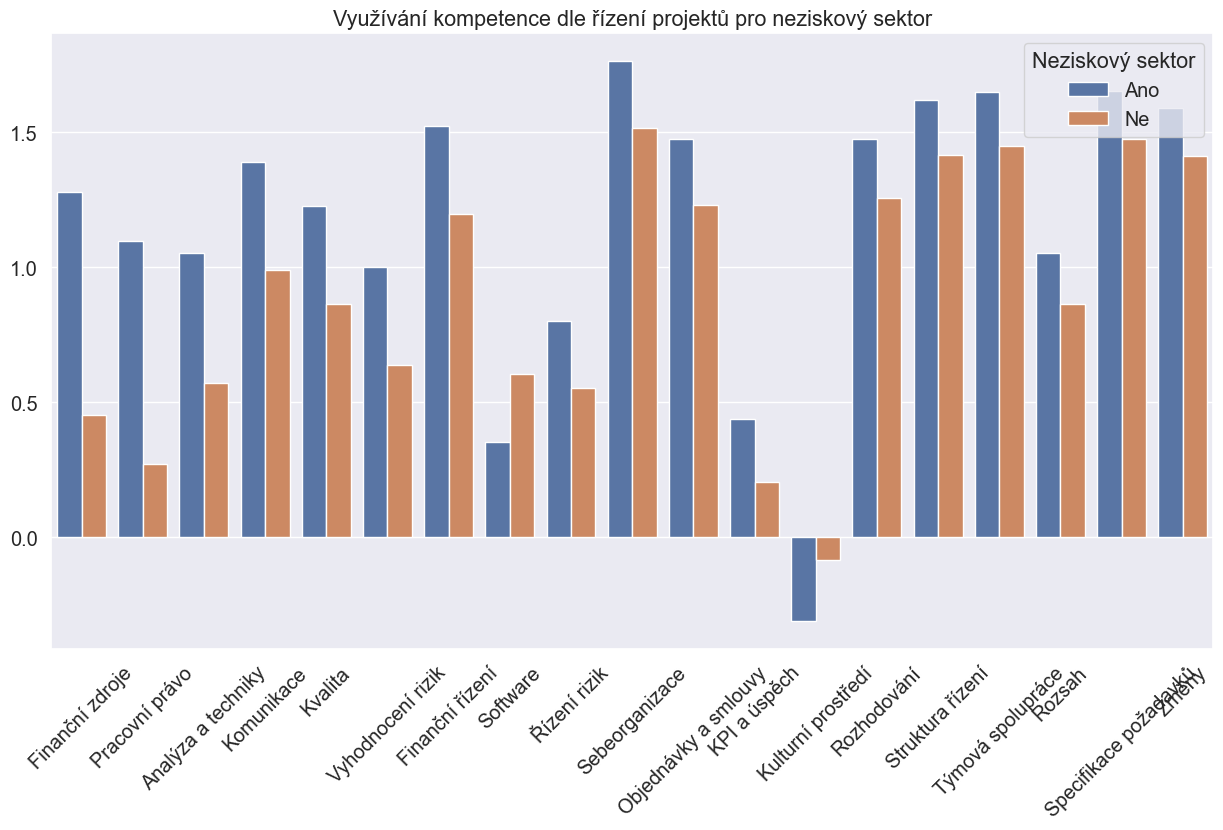

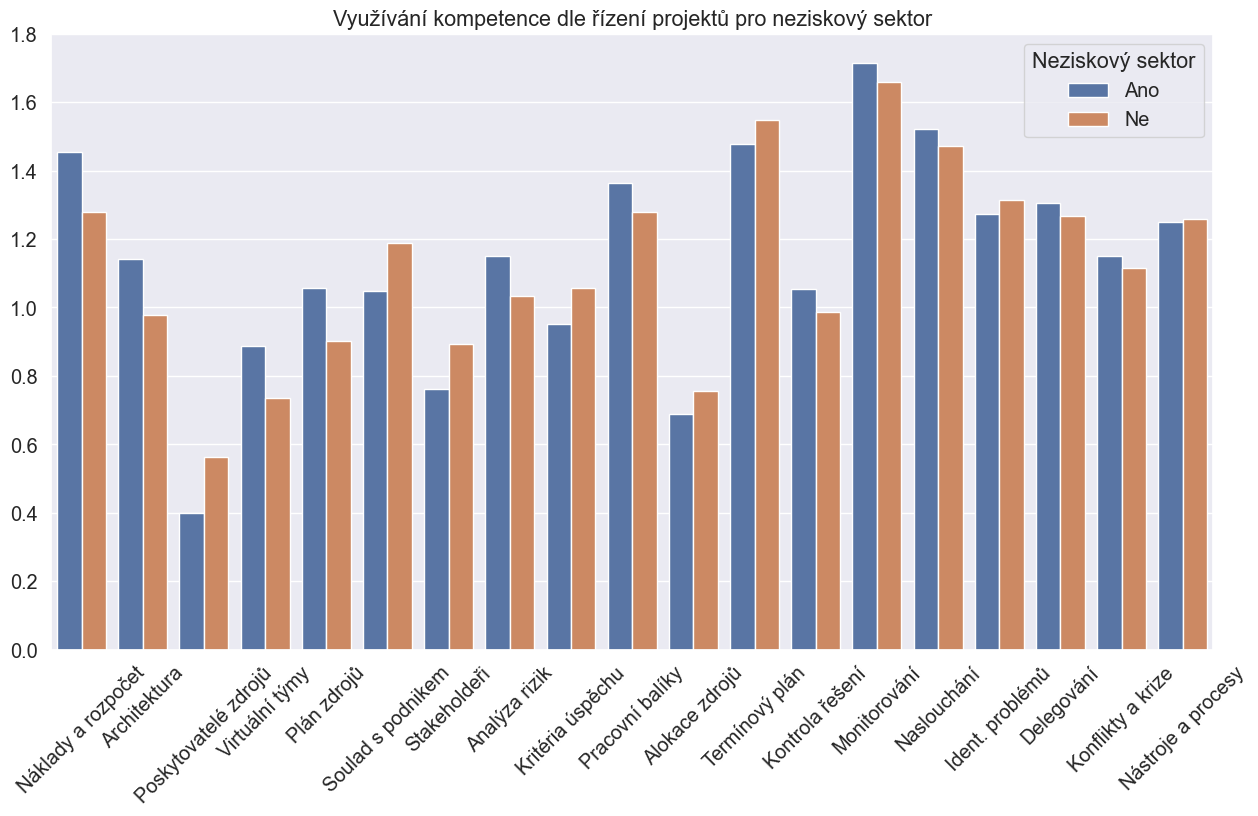

In [22]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 'Využívání kompetence dle řízení projektů pro neziskový sektor', 
               "Jaké typy projektu řídíte? x pro neziskový sektor", "Neziskový sektor")

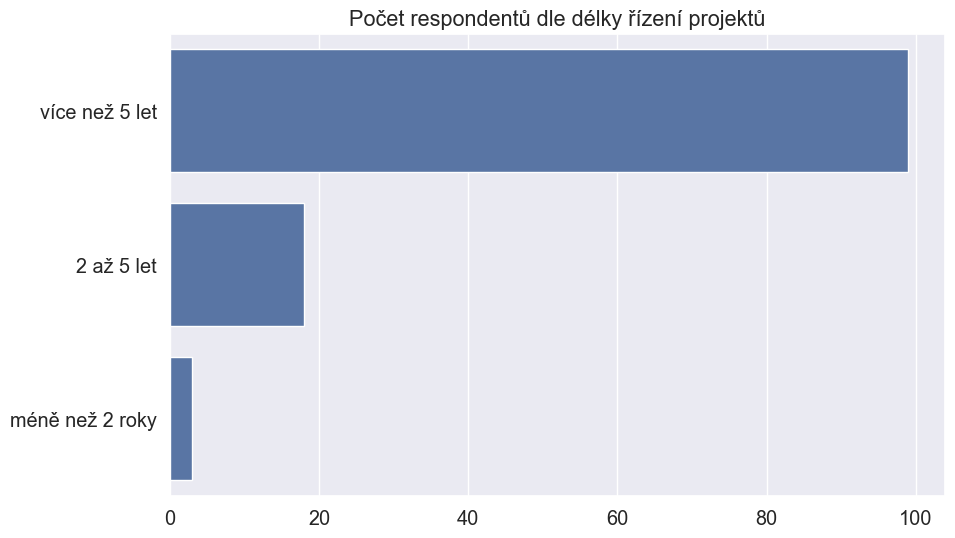

In [23]:
count_plot(df, "Počet respondentů dle délky řízení projektů", "Jak dlouho řídíte projekty?")

In [24]:
df_filtered_usage

Specifikace požadavků  Architektura  Kritéria úspěchu  Termínový plán  \
0                      2.0           NaN               2.0             2.0   
1                      2.0           2.0               2.0             2.0   
2                      2.0           2.0               2.0             2.0   
3                      2.0           2.0               2.0             2.0   
4                      2.0          -1.0              -2.0             2.0   
..                     ...           ...               ...             ...   
115                    1.0           1.0               2.0             2.0   
116                    2.0          -1.0               1.0             1.0   
117                    1.0          -1.0              -2.0            -1.0   
118                    2.0           1.0               1.0             2.0   
119                    NaN           NaN               1.0             2.0   

     Monitorování  Změny  Finanční řízení  Náklady a rozpočet  \
0             2.0    2.0              2.0                 2.0   
1             2.0    2.0              2.0                 2.0   
2             2.0    2.0              2.0                 2.0   
3             2.0    2.0              2.0                 2.0   
4             2.0    1.0              2.0                 2.0   
..            ...    ...              ...                 ...   
115           2.0    1.0              1.0                 1.0   
116           2.0    2.0              2.0                 2.0   
117           2.0    2.0              2.0                 2.0   
118           2.0    2.0              1.0                 2.0   
119           2.0    2.0              2.0                 2.0   

     Finanční zdroje  Pracovní balíky  ...  Komunikace  Naslouchání  \
0                2.0              2.0  ...         2.0          2.0   
1                2.0              2.0  ...         2.0          1.0   
2                1.0              2.0  ...         1.0          2.0   
3                2.0              2.0  ...         2.0          1.0   
4                2.0              1.0  ...         1.0          1.0   
..               ...              ...  ...         ...          ...   
115              1.0              1.0  ...         2.0          2.0   
116              2.0              2.0  ...         2.0          2.0   
117              2.0              1.0  ...         2.0          2.0   
118              NaN              2.0  ...         2.0          NaN   
119              NaN              2.0  ...         1.0         -1.0   

     Virtuální týmy  Pracovní právo  Stakeholdeři  Rozhodování  \
0               2.0             2.0           2.0          2.0   
1               NaN             2.0           NaN          2.0   
2               1.0            -1.0          -1.0         -1.0   
3               NaN             NaN          -1.0          NaN   
4              -2.0             2.0          -2.0          2.0   
..              ...             ...           ...          ...   
115             NaN             NaN           1.0          1.0   
116             2.0             2.0           2.0          2.0   
117            -1.0             2.0           1.0         -1.0   
118            -1.0             1.0           2.0          2.0   
119             1.0             2.0           1.0          NaN   

     Konflikty a krize  Objednávky a smlouvy  Kulturní prostředí  \
0                  1.0                   2.0                 NaN   
1                  2.0                   2.0                 2.0   
2                  1.0                   2.0                -2.0   
3                  1.0                   1.0                 NaN   
4                  1.0                   2.0                -1.0   
..                 ...                   ...                 ...   
115                NaN                   1.0                 1.0   
116                2.0                   2.0                 1.0   
117                2.0       

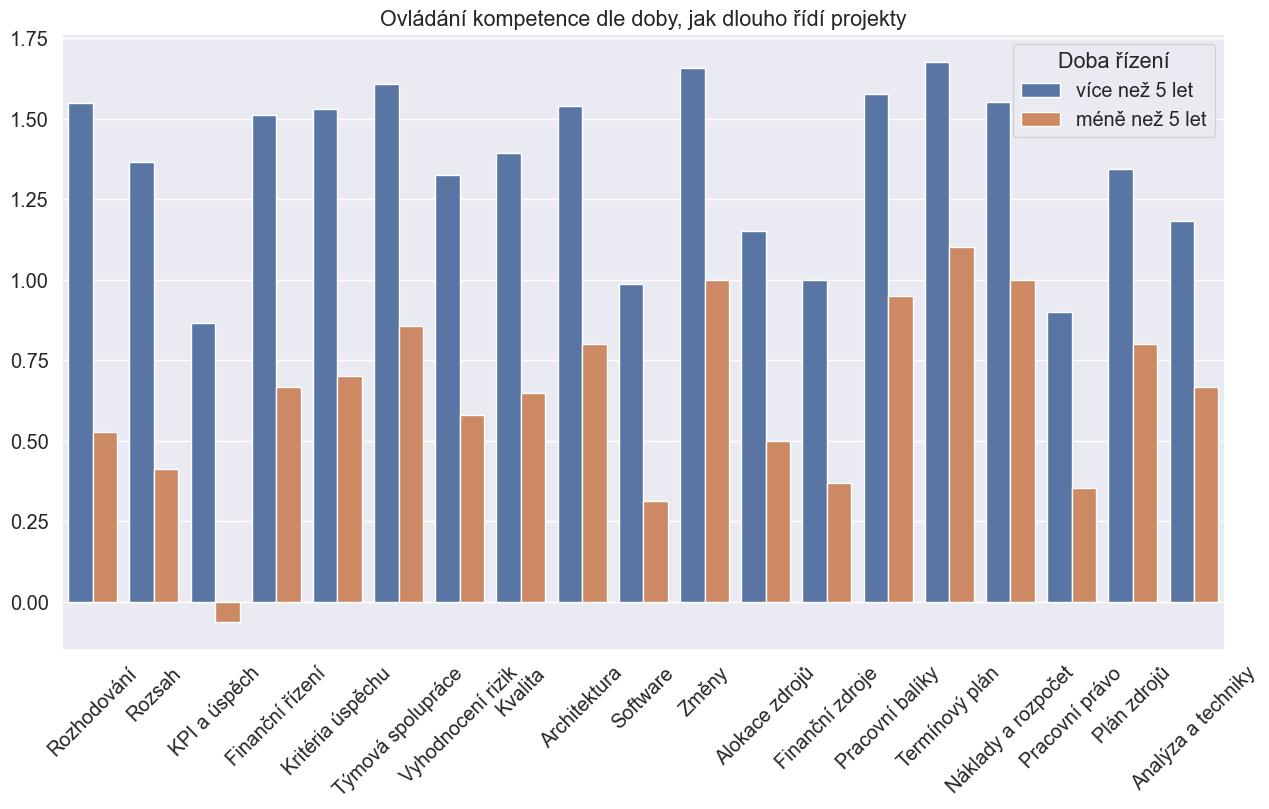

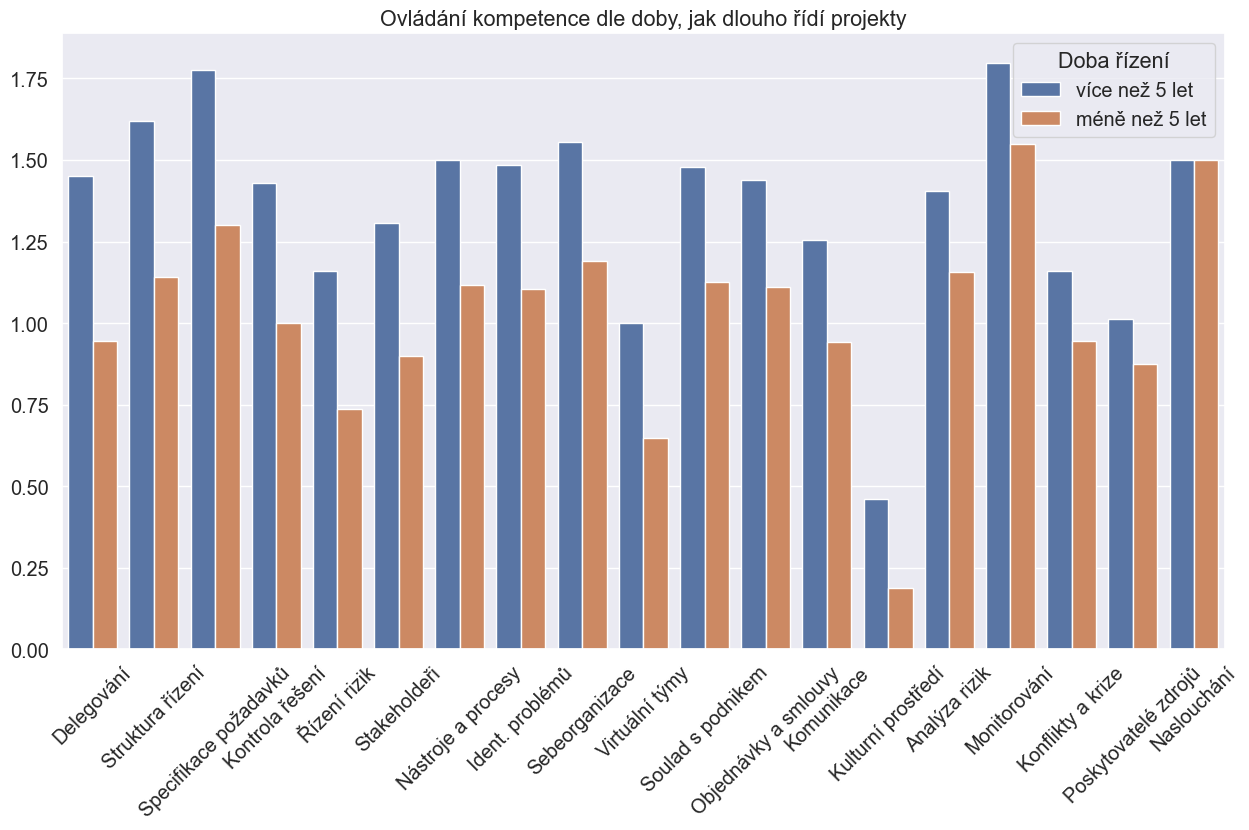

In [25]:
df["Jak dlouho řídíte projekty?"] = df["Jak dlouho řídíte projekty?"].str.replace("méně než 2 roky", "2 až 5 let")
df["Jak dlouho řídíte projekty?"] = df["Jak dlouho řídíte projekty?"].str.replace("2 až 5 let", "méně než 5 let")
hue_plot_usage(df, "x vůbec neovládám x zcela ovládám", 'Ovládání kompetence dle doby, jak dlouho řídí projekty', "Jak dlouho řídíte projekty?", "Doba řízení")

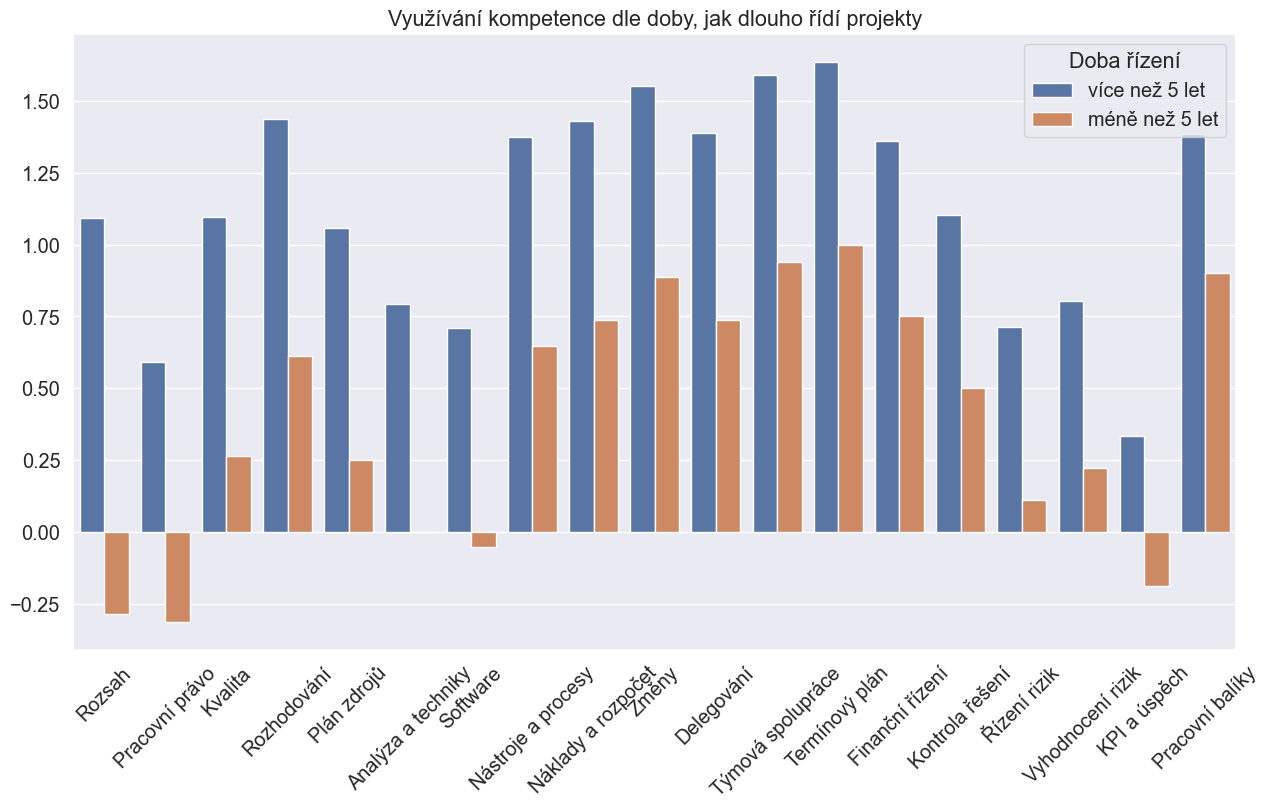

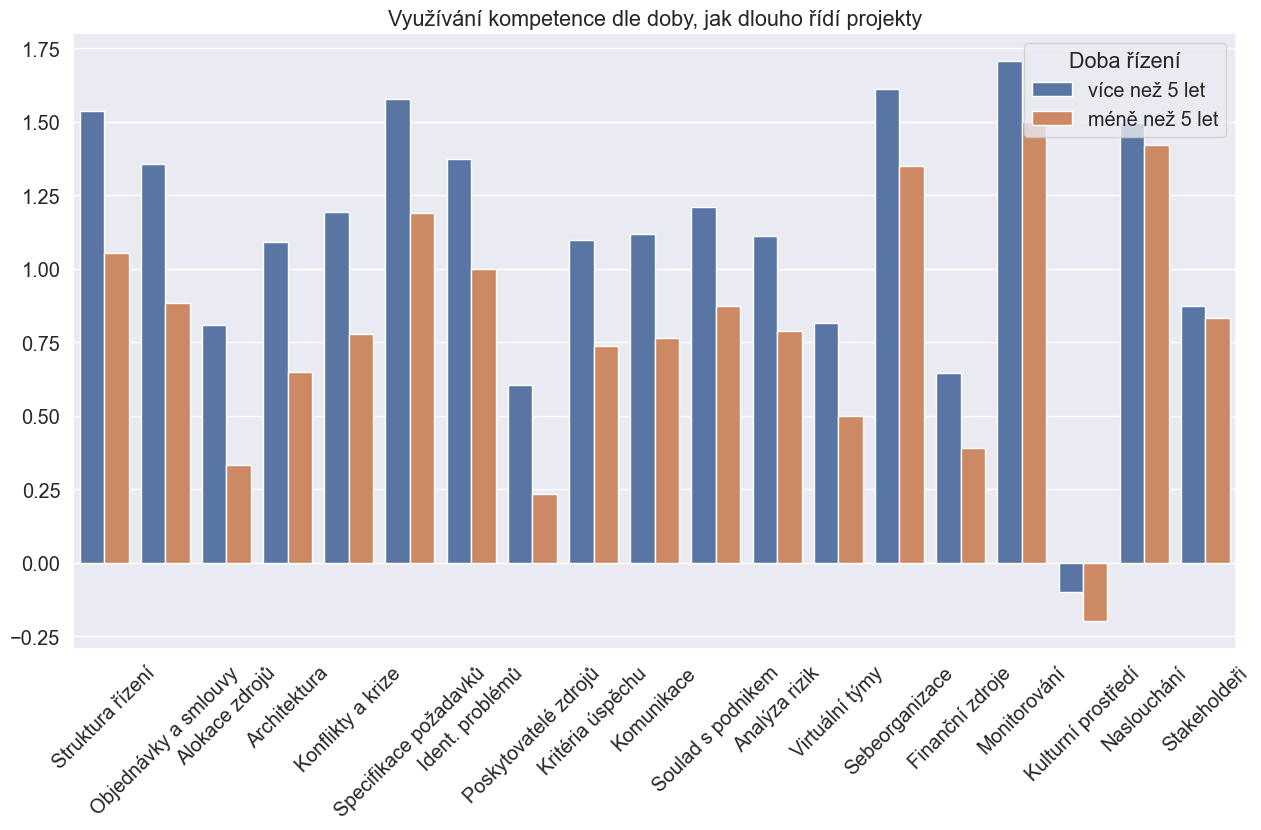

In [26]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 'Využívání kompetence dle doby, jak dlouho řídí projekty', "Jak dlouho řídíte projekty?", "Doba řízení")

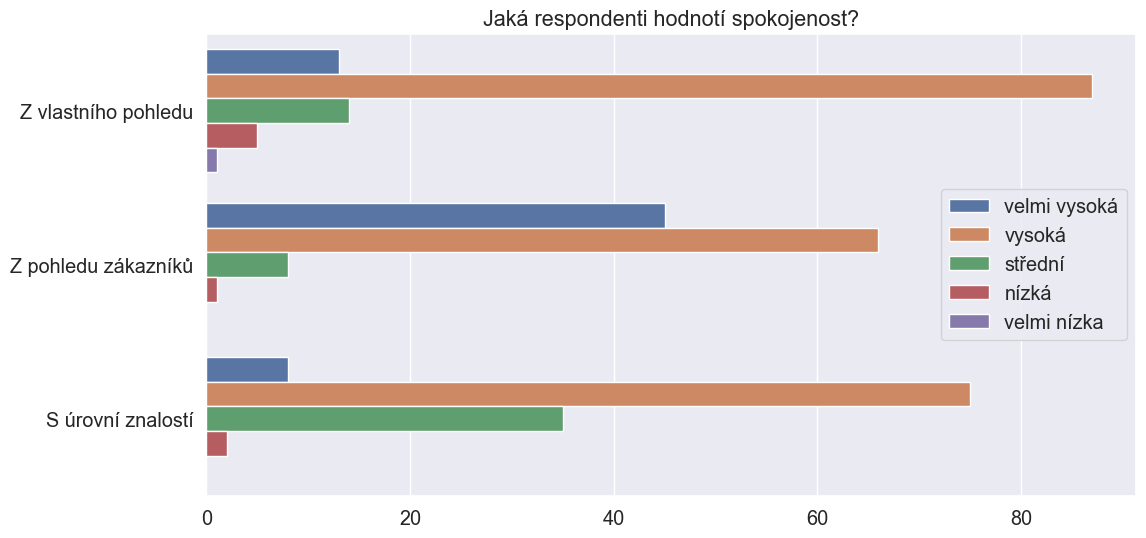

In [27]:
columns = [
    "S tím, jak aktuálně vedete projekty, jste",
    "S výsledky projektů, které vedu, jsou zákazníci",
    "Úroveň mých znalostí projektového řízení považuji celkově za"
]

# Melt the DataFrame so we have 'Project Type' and 'Response' columns
melted_df = df[columns].melt(var_name='Satisfaction', value_name='Response')

response_mapping = {
    'velmi spokojen(a)': 'velmi vysoká',
    'spíše spokojen(a)': 'vysoká',
    'ani spokojen(a), ani nespokojen(a)': 'střední',
    'spíše nespokojen(a)': 'nízká',
    'velmi nespokojen(a)': 'velmi nízka',
    'velmi spokojeni': 'velmi vysoká',
    'spíše spokojeni': 'vysoká',
    'ani spokojeni, ani nespokojeni': 'střední',
    'spíše nespokojeni': 'nízká',
    'průměrnou': 'střední',
    'vynikající': 'velmi vysoká',
    'nadprůměrnou': 'vysoká',
    'podprůměrnou': 'nízká'
}

satisfaction_mapping = {
    "S tím, jak aktuálně vedete projekty, jste": "Z vlastního pohledu",
    "S výsledky projektů, které vedu, jsou zákazníci": "Z pohledu zákazníků",
    "Úroveň mých znalostí projektového řízení považuji celkově za": "S úrovní znalostí",
}
melted_df['Response'] = melted_df['Response'].map(response_mapping)
melted_df['Satisfaction'] = melted_df['Satisfaction'].map(satisfaction_mapping)
response_order = ['velmi vysoká', 'vysoká', 'střední', 'nízká', 'velmi nízka']

# Create the count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=melted_df, y='Satisfaction', hue='Response', hue_order=response_order)

# Enhance plot aesthetics
plt.title("Jaká respondenti hodnotí spokojenost?")
plt.xlabel("")
plt.ylabel("")
plt.legend()

In [28]:
df["S výsledky projektů, které vedu, jsou zákazníci"] = df["S výsledky projektů, které vedu, jsou zákazníci"].str.replace("spíše nespokojeni", "ani spokojeni, ani nespokojeni")
df["Jak dlouho řídíte projekty?"] = df["Jak dlouho řídíte projekty?"].str.replace("2 až 5 let", "méně než 5 let")

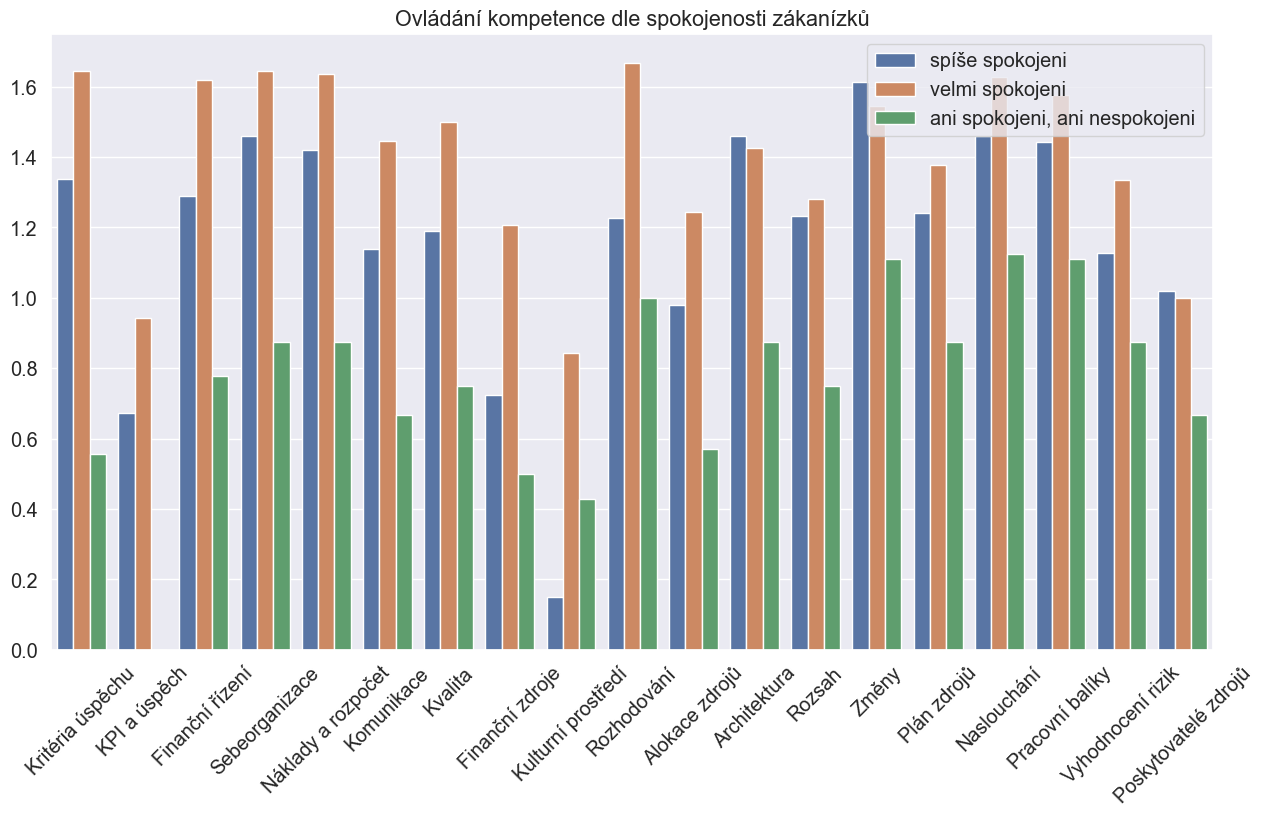

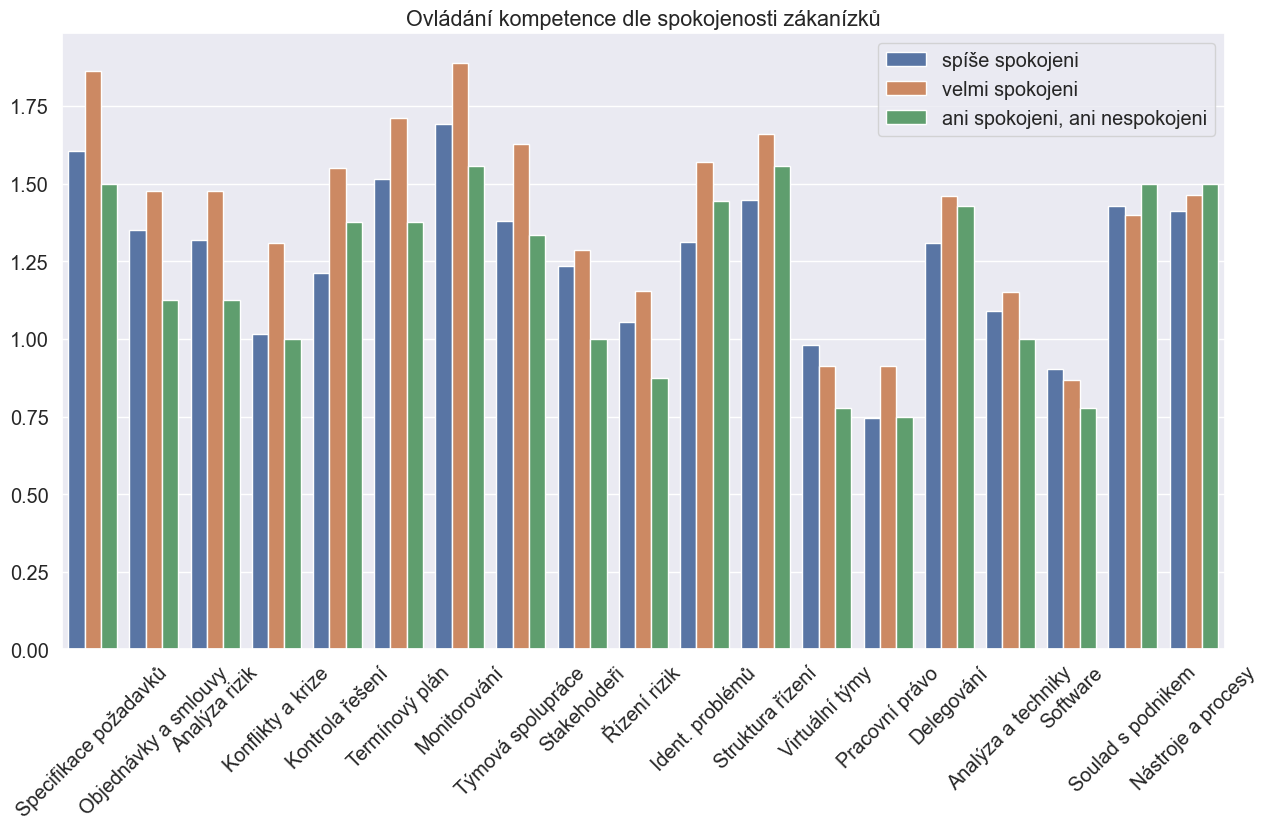

In [29]:
hue_plot_usage(df, "x vůbec neovládám x zcela ovládám", 'Ovládání kompetence dle spokojenosti zákanízků', 
               "S výsledky projektů, které vedu, jsou zákazníci", "")

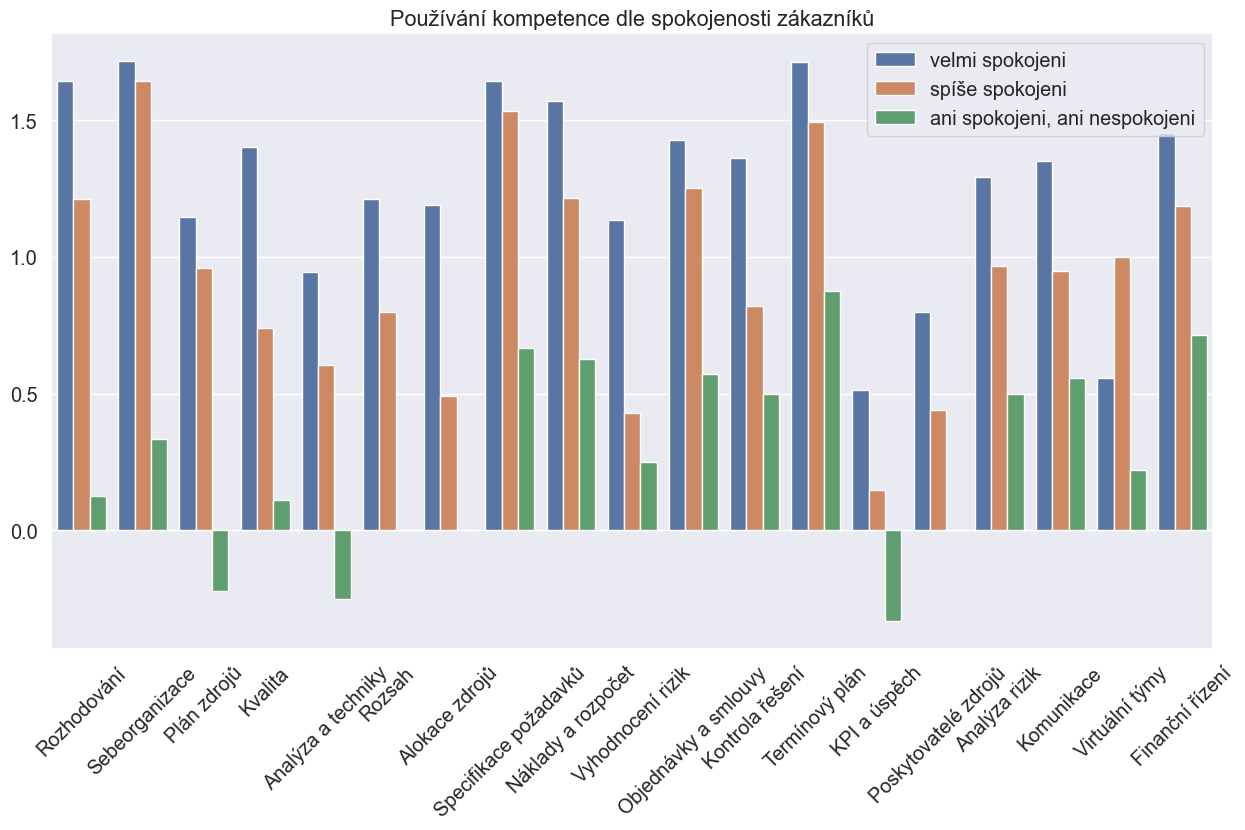

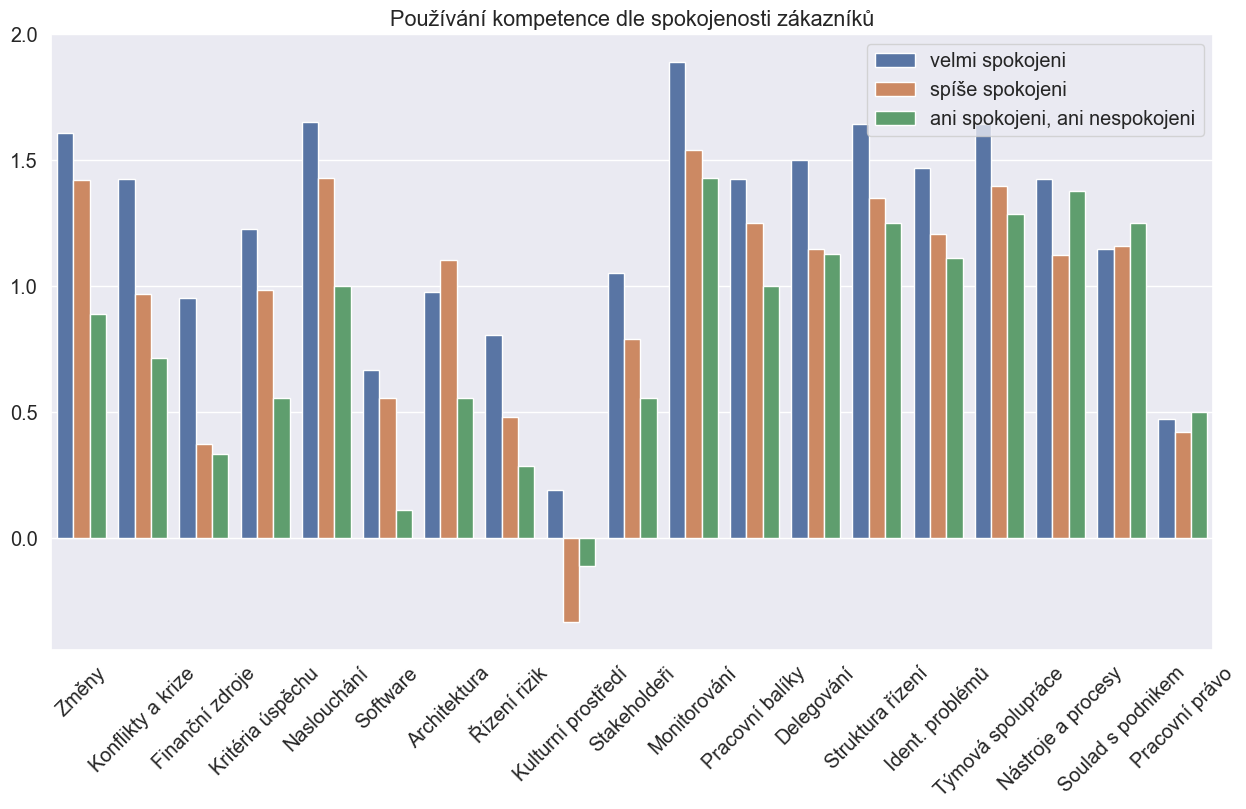

In [30]:
hue_plot_usage(df, "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", 'Používání kompetence dle spokojenosti zákazníků', 
               "S výsledky projektů, které vedu, jsou zákazníci", "", ["velmi spokojeni", "spíše spokojeni", "ani spokojeni, ani nespokojeni"])

In [31]:
search_string = "x vůbec neovládám x zcela ovládám"

filtered_columns = [col for col in df.columns if search_string in col] + list(satisfaction_mapping.keys())
df_comparsion = df[filtered_columns]
df_comparsion = df_comparsion.rename(columns=lambda x: x.replace(search_string, ""))
df_comparsion = update_column_names(df_comparsion)
for col in list(satisfaction_mapping.keys()):
    df_comparsion[col] = df_comparsion[col].map(response_mapping)
    df_comparsion[col] = df_comparsion[col].str.replace("velmi nízka", "střední")
    df_comparsion[col] = df_comparsion[col].str.replace("nízká", "střední")

df_comparsion_final = None
for item in list(satisfaction_mapping.keys()):
    prefix = ""
    if item == "S tím, jak aktuálně vedete projekty, jste":
        prefix = "vlastní spokojenost"
    elif item == "S výsledky projektů, které vedu, jsou zákazníci":
        prefix = "zákazníci"
    elif item == "Úroveň mých znalostí projektového řízení považuji celkově za":
        prefix = "znalosti"
    if not isinstance(df_comparsion_final, pd.DataFrame):
        df_comparsion_final = df_comparsion.groupby(item).mean(numeric_only=True).T
        df_comparsion_final[f"{prefix} vysoká - střední"] = df_comparsion_final["vysoká"] - df_comparsion_final["střední"]
        df_comparsion_final[f"{prefix} velmi vysoká - vysoká"] = df_comparsion_final["velmi vysoká"] - df_comparsion_final["vysoká"]
        df_comparsion_final[f"{prefix} průměrná změna"] = (df_comparsion_final[f"{prefix} vysoká - střední"] + df_comparsion_final[f"{prefix} velmi vysoká - vysoká"]) / 2
        df_comparsion_final = df_comparsion_final[[f"{prefix} vysoká - střední", f"{prefix} velmi vysoká - vysoká", f"{prefix} průměrná změna"]]
    else:
        df_comparsion_final_pom = df_comparsion.groupby(item).mean(numeric_only=True).T
        df_comparsion_final_pom[f"{prefix} vysoká - střední"] = df_comparsion_final_pom["vysoká"] - df_comparsion_final_pom["střední"]
        df_comparsion_final_pom[f"{prefix} velmi vysoká - vysoká"] = df_comparsion_final_pom["velmi vysoká"] - df_comparsion_final_pom["vysoká"]
        df_comparsion_final_pom[f"{prefix} průměrná změna"] = (df_comparsion_final_pom[f"{prefix} vysoká - střední"] + df_comparsion_final_pom[f"{prefix} velmi vysoká - vysoká"]) / 2 
        df_comparsion_final = pd.merge(df_comparsion_final, df_comparsion_final_pom[[f"{prefix} vysoká - střední", f"{prefix} velmi vysoká - vysoká", f"{prefix} průměrná změna"]], left_index=True, right_index=True)
df_comparsion_final = df_comparsion_final.reset_index(drop=False)

def group(item):
    mapping = ""
    for key, value in column_name_mapping.items():
        if item == value:
            mapping = key
            break
    return column_group_mapping[mapping]

df_comparsion_final["group"] = df_comparsion_final["index"].map(group)
df_comparsion_final = df_comparsion_final.drop(columns=["index"])
df_comparsion_final = df_comparsion_final.groupby("group").mean()
df_comparsion_final.to_excel("kompetence výběr modulů.xlsx", index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


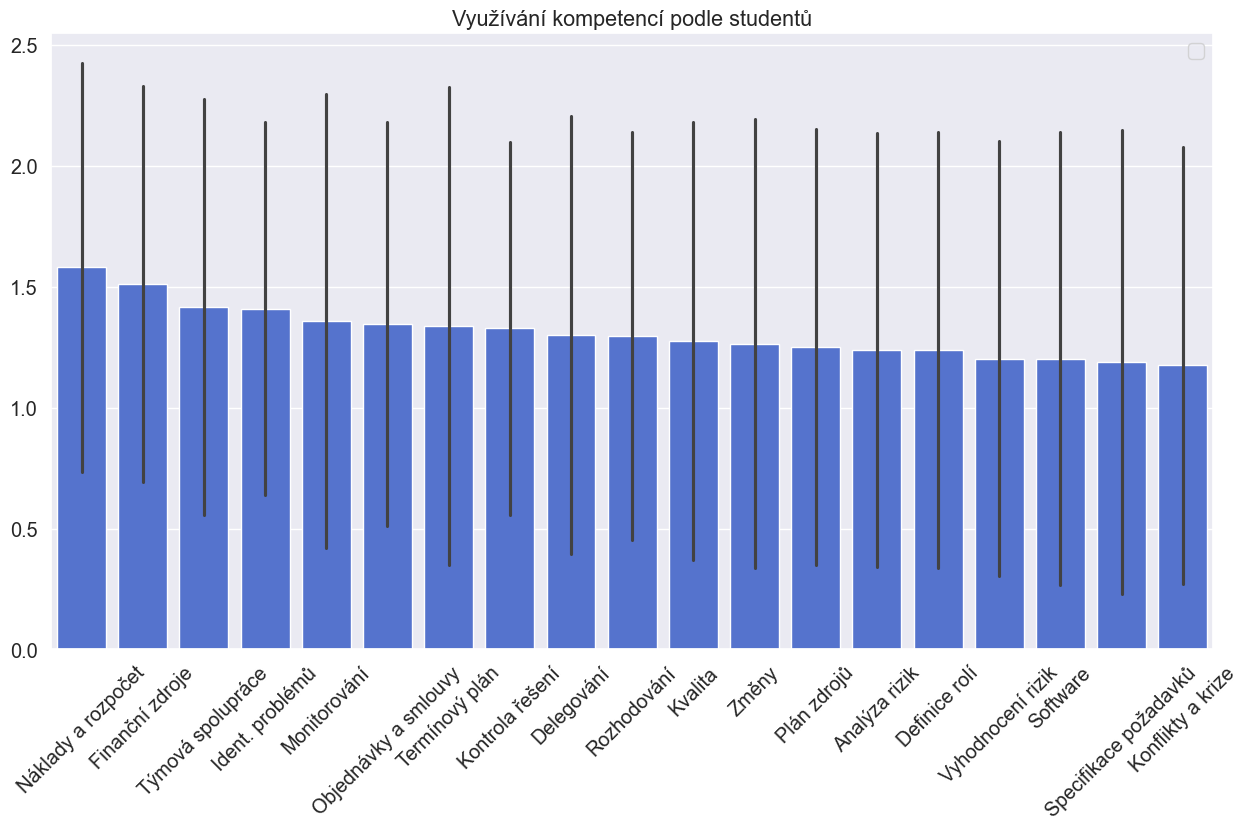

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


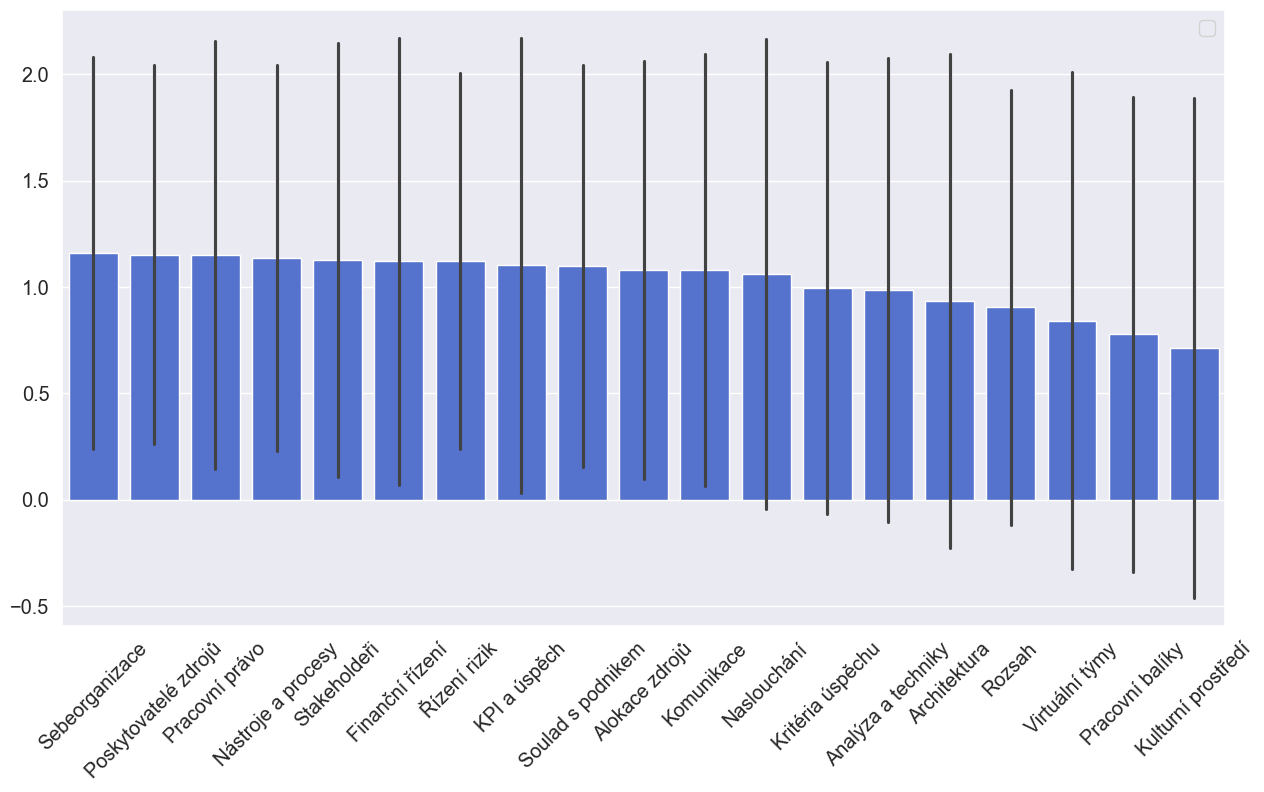

In [32]:
search_string = "x v praxi se vůbec nepoužívá x v praxi se používá velmi intenzivně"
hue_plot_usage(df_students, search_string, 'Využívání kompetencí podle studentů')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


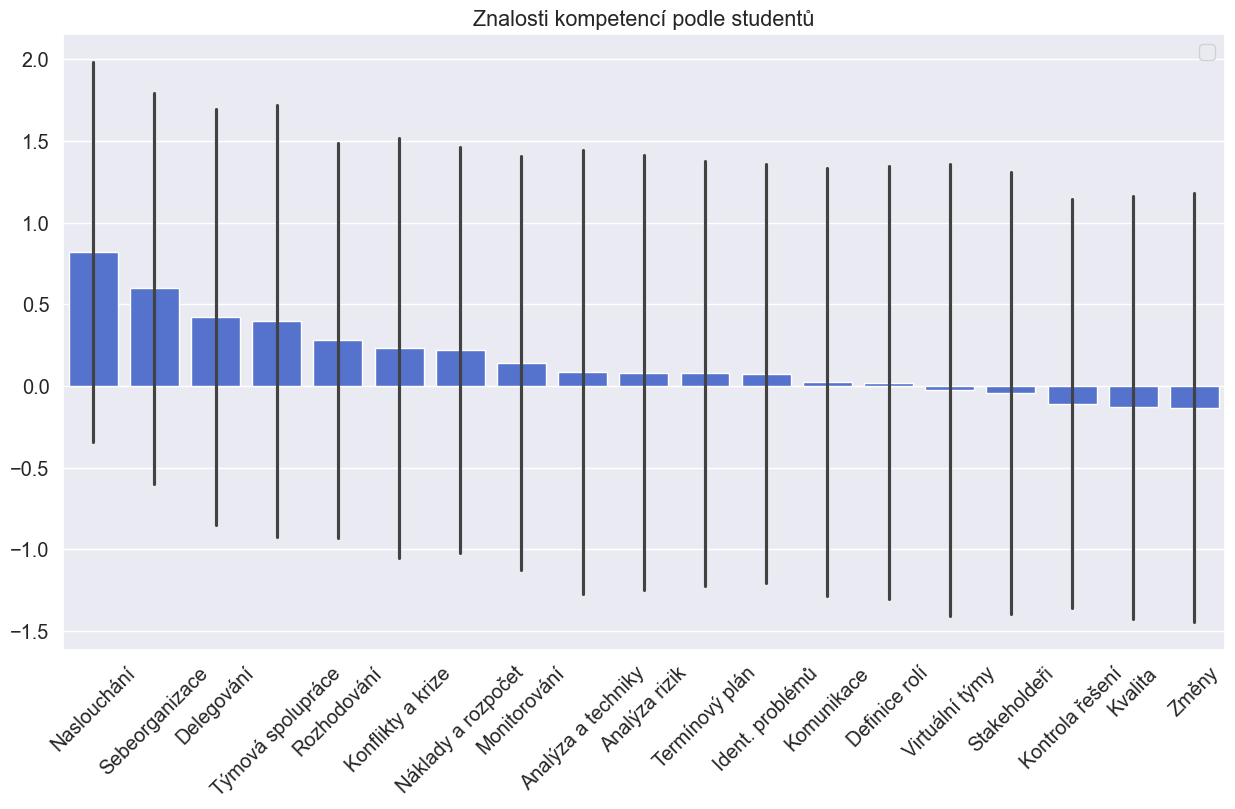

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


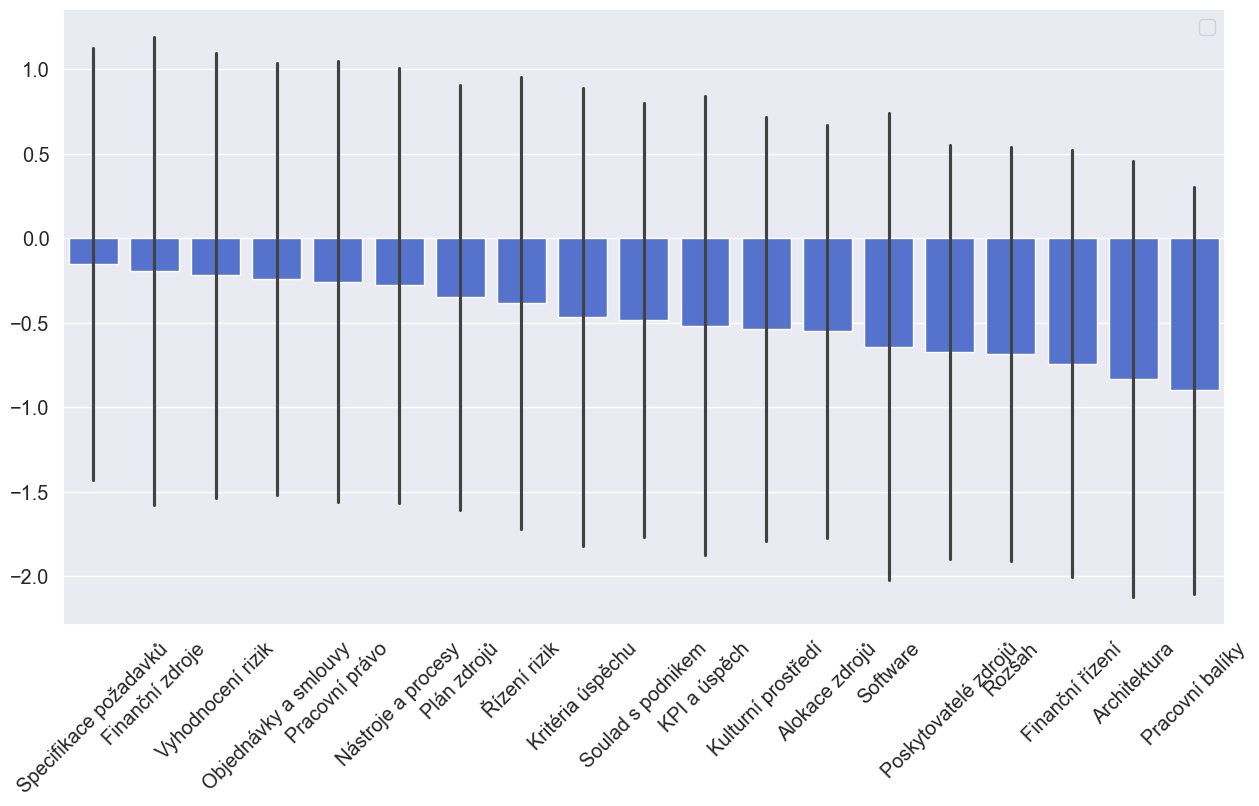

In [33]:
search_string = "x nemám žádné znalosti x mám perfektní znalosti"
hue_plot_usage(df_students, search_string, 'Znalosti kompetencí podle studentů')

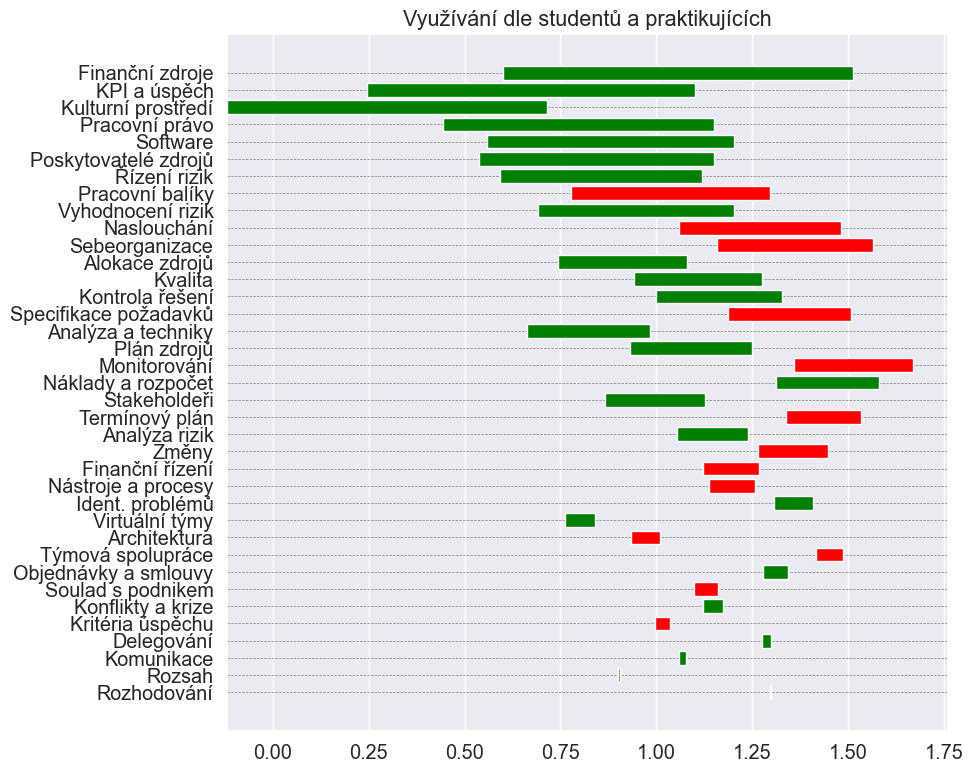

In [34]:
search_string = "x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně"

filtered_columns = [col for col in df.columns if search_string in col]
df_filtered_usage = df[filtered_columns]
df_filtered_usage = df_filtered_usage.rename(columns=lambda x: x.replace(search_string, ""))
df_filtered_usage = update_column_names(df_filtered_usage)
df_filtered_usage = df_filtered_usage.mean().to_frame(name="Praktikující")

search_string = "x v praxi se vůbec nepoužívá x v praxi se používá velmi intenzivně"

filtered_columns = [col for col in df_students.columns if search_string in col]
df_filtered_students_usage = df_students[filtered_columns]
df_filtered_students_usage = df_filtered_students_usage.rename(columns=lambda x: x.replace(search_string, ""))
df_filtered_students_usage = update_column_names(df_filtered_students_usage)
df_filtered_students_usage = df_filtered_students_usage.mean().to_frame(name="Studenti")

df_avg = pd.merge(df_filtered_usage, df_filtered_students_usage, left_index=True, right_index=True)
plot_diff_avg(df_avg, "Studenti", "Praktikující", "Využívání dle studentů a praktikujících")

In [35]:
df_export = df
df_export = update_column_names(df_export)
df_export

Datum       Čas Dokončeno za        Zdroj  \
0    2024-03-25  10:36:09     00:05:19  Přímý odkaz   
1    2024-03-19  18:00:36     00:28:10  Přímý odkaz   
2    2024-03-19  14:47:54     00:16:03  Přímý odkaz   
3    2024-03-19  08:08:15     00:34:58  Přímý odkaz   
4    2024-03-18  09:19:28     00:09:33  Přímý odkaz   
..          ...       ...          ...          ...   
115  2024-02-19  09:53:41     00:05:52  Přímý odkaz   
116  2024-02-19  09:37:44     00:07:33  Přímý odkaz   
117  2024-02-18  09:15:36     00:06:05  Přímý odkaz   
118  2024-02-15  17:09:20     00:14:38  Přímý odkaz   
119  2024-02-13  10:51:04     00:18:54  Přímý odkaz   

     Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu x vůbec neovládám x zcela ovládám  \
0                                                  2.0                                                               
1                                                  2.0                                                               
2                                                  2.0                                                               
3                                                  2.0                                                               
4                                                  2.0                                                               
..                                                 ...                                                               
115                                                2.0                                                               
116                                                2.0                                                               
117                                                2.0                                                               
118                                                2.0                                                               
119                                                1.0                                                               

     Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně  \
0                                                  2.0                                                                                            
1                                                  2.0                                                                                            
2                                                  2.0                                                                                            
3                                                  2.0                                                                                            
4                                                  2.0                                                                                            
..                                                 ...                                                                                            
115                                                1.0                                                                                            
116                                                2.0                                                                                            
117                                                1.0                                                                                            
118                                                2.0                                                                                            
119                                                NaN                                                                                            

     Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) x vůbec neovládám x zcela ovládám  \
0         

In [36]:
column_group_mapping = {
    'Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu ': 'Requirements and objectives',
    'Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) ': 'Project design',
    'Stanovení kritérií úspěchu projektu a využití lessons learned z jiných projektů ': 'Project design',
    'Stanovení termínového plánu projektu včetně odhadu pracnosti a doby trvání jednotlivých aktivit ': ' Time',
    'Monitorování, reportování a vyhodnocování průběhu projektu a přijímání nezbytných opatření ': 'Plan and control the project execution',
    "Monitorování, reportování a vyhodnocování průběhu projektu a příjímání nezbytných opatření ": 'Plan and control the project execution',
    'Posouzení, vyjednání a implementace změny projektu ': 'Plan and control the project execution',
    'Vytvoření a udržování systému finančního řízení a reportingu a monitorování stavu projektových financí ': 'Finance',
    'Odhad (a kalkulace) nákladů projektu včetně vytvoření rozpočtu ': 'Finance',
    'Zajištění finančních zdrojů projektu ': 'Finance',
    'Definice výstupů a pracovních balíků projektu, sestavení jejich hierarchie ': 'Scope',
    'Monitorování rozsahu projektu a zabránení nepožadovanému překročení rozsahu projektu ': 'Scope',
    'Identifikace a analýza rizik a příležitostí a posouzení jejich pravděpodobnosti výskytu a dopad na projekt ': 'Risk and opportunity',
    'Zpracování a implementace postupu pro řízení rizik ': 'Risk and opportunity',
    'Monitorování a vyhodnocování rizik, příležitostí a implementace opatření ': 'Risk and opportunity',
    'Naplánování, organizace a ověření dosažení cílů kvality projektu a doporučení nezbytných nápravných a/nebo preventivních opatření ': 'Quality',
    'Zajištění souladu projektu s prostředím a procesy podniku ': 'Governance, structures and processes',
    'Identifikace problémů, jejich příčin a vlivu na projekt, návrh a volba vhodných řešení ': 'Problem solving',
    'Kontrola a vyhodnocení implementovaných řešení problémů ': 'Problem solving',
    'Definování struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ': 'Organisation and information',
    'Stanovení nástrojů, procesů a systémů pro řízení projektu a předávání informací ': 'Organisation and information',
    'Volba a efektivní ovládání software pro řízení projektu včetně informačních toků ': 'Organisation and information',
    'Sestavení projektového týmu, podpora spolupráce a budování vztahů mezi členy týmu ': 'Teamwork',
    'Posilování týmu delegováním úkolů, odpovědností a učením se z chyb ': 'Teamwork',
    'Definice množství požadovaných zdrojů, sestavení plánu zdrojů pro realizaci a dodání projektu ': 'Resources',
    'Identifikace potenciálních poskytovatelů zdrojů a vyjednávání o jejich poskytnutí ': 'Resources',
    'Alokace a distribuce zdrojů podle definované potřeby, vyhodnocení jejich využití a provedení případných nápravných opatření ': 'Resources',
    'Určení, ohodnocení a přezkoumání KPI (klíčové ukazatele výkonnosti) projektu a kritické faktory jeho úspěchu ': 'Strategy',
    'Aplikace analytických a kreativních technik (např. kritické a koncepční myšlení, stanovení priorit, brainstorming aj.) na analýzu situací, finančních a organizačních dat a trendů ': 'Resourcefulness',
    'Volba komunikačního stylu a kanálů s ohledem na potřeby publika a situace, poskytování jasných a strukturovaných informací a ověřování porozumění ': 'Personal communication',
    'Aktivní naslouchání a podpora otevřené komunikace ': 'Personal communication',
    'Zajištění efektivní komunikace s virtuálními týmy ': 'Personal communication',
    'Znalost základů pracovního práva (např. zákoník práce, zákon o zadávání veřejných zakázek) ': 'Compliance, standards and regulations',
    'Identifikace zainteresovaných stran (stakeholderů), analýza jejich zájmu a vlivu a udržování dobrých vztahů ': 'Stakeholders',
    'Rozhodování a prosazování rozhodnutí a přijímání odpovědnosti ': 'Leadership',
    "Rozhodování a prosazování rozhodnutí a příjmání odpovědnosti ": "Leadership",
    'Předvídání a předcházení konfliktům a krizím ': 'Conflict and crisis',
    'Dohlížení na plnění objednávek a smluv, řešení problémů a v případě potřeby vyhledávání nápravy ': 'Procurement',
    'Posouzení charakteru a hodnoty kulturního prostředí a jejich důsledků pro projekt ': 'Relationships and engagements',
    'Organizace vlastní práce dle situace a vlastních zdrojů ': 'Self-reflection and self-management',
    "Definice struktury řízení projektu, rolí a odpovědností v rámci projektového týmu ": "Teamwork",
}

df = pd.DataFrame(list(column_group_mapping.items()), columns=['Activity', 'Project Area'])
df.head()
df.to_excel("skupiny kompetencí.xlsx")

In [37]:
import pandas as pd

# Dictionary representation of the given data
project_management_skills = {
    "Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu x vůbec neovládám x zcela ovládám": "x1",
    "Stanovení požadavků a dílčích projektových cílů v souladu s účelem projektu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x2",
    "Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) x vůbec neovládám x zcela ovládám": "x3",
    "Návrh architektury (hrubý náčrt plánu) realizace projektu včetně volby přístupu k realizaci projektu (např. agile) x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x4",
    "Stanovení kritérií úspěchu projektu a využití lessons learned z jiných projektů x vůbec neovládám x zcela ovládám": "x5",
    "Stanovení kritérií úspěchu projektu a využití lessons learned z jiných projektů x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x6",
    "Stanovení termínového plánu projektu včetně odhadu pracnosti a doby trvání jednotlivých aktivit x vůbec neovládám x zcela ovládám": "x7",
    "Stanovení termínového plánu projektu včetně odhadu pracnosti a doby trvání jednotlivých aktivit x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x8",
    "Monitorování, reportování a vyhodnocování průběhu projektu a přijímání nezbytných opatření x vůbec neovládám x zcela ovládám": "x9",
    "Monitorování, reportování a vyhodnocování průběhu projektu a přijímání nezbytných opatření x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x10",
    "Posouzení, vyjednání a implementace změny projektu x vůbec neovládám x zcela ovládám": "x11",
    "Posouzení, vyjednání a implementace změny projektu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x12",
    "Vytvoření a udržování systému finančního řízení a reportingu a monitorování stavu projektových financí x vůbec neovládám x zcela ovládám": "x13",
    "Vytvoření a udržování systému finančního řízení a reportingu a monitorování stavu projektových financí x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x14",
    "Odhad (a kalkulace) nákladů projektu včetně vytvoření rozpočtu x vůbec neovládám x zcela ovládám": "x15",
    "Odhad (a kalkulace) nákladů projektu včetně vytvoření rozpočtu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x16",
    "Zajištění finančních zdrojů projektu x vůbec neovládám x zcela ovládám": "x17",
    "Zajištění finančních zdrojů projektu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x18",
    "Definice výstupů a pracovních balíků projektu, sestavení jejich hierarchie x vůbec neovládám x zcela ovládám": "x19",
    "Definice výstupů a pracovních balíků projektu, sestavení jejich hierarchie x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x20",
    "Monitorování rozsahu projektu a zabránení nepožadovanému překročení rozsahu projektu x vůbec neovládám x zcela ovládám": "x21",
    "Monitorování rozsahu projektu a zabránení nepožadovanému překročení rozsahu projektu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x22",
    "Identifikace a analýza rizik a příležitostí a posouzení jejich pravděpodobnosti výskytu a dopad na projekt x vůbec neovládám x zcela ovládám": "x23",
    "Identifikace a analýza rizik a příležitostí a posouzení jejich pravděpodobnosti výskytu a dopad na projekt x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x24",
    "Zpracování a implementace postupu pro řízení rizik x vůbec neovládám x zcela ovládám": "x25",
    "Zpracování a implementace postupu pro řízení rizik x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x26",
    "Monitorování a vyhodnocování rizik, příležitostí a implementace opatření x vůbec neovládám x zcela ovládám": "x27",
    "Monitorování a vyhodnocování rizik, příležitostí a implementace opatření x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x28",
    "Naplánování, organizace a ověření dosažení cílů kvality projektu a doporučení nezbytných nápravných a/nebo preventivních opatření x vůbec neovládám x zcela ovládám": "x29",
    "Naplánování, organizace a ověření dosažení cílů kvality projektu a doporučení nezbytných nápravných a/nebo preventivních opatření x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x30",
    "Zajištění souladu projektu s prostředím a procesy podniku x vůbec neovládám x zcela ovládám": "x31",
    "Zajištění souladu projektu s prostředím a procesy podniku x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x32",
    "Identifikace problémů, jejich příčin a vlivu na projekt, návrh a volba vhodných řešení x vůbec neovládám x zcela ovládám": "x33",
    "Identifikace problémů, jejich příčin a vlivu na projekt, návrh a volba vhodných řešení x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x34",
    "Kontrola a vyhodnocení implementovaných řešení problémů x vůbec neovládám x zcela ovládám": "x35",
    "Kontrola a vyhodnocení implementovaných řešení problémů x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x36",
    "Definování struktury řízení projektu, rolí a odpovědností v rámci projektového týmu x vůbec neovládám x zcela ovládám": "x37",
    "Definování struktury řízení projektu, rolí a odpovědností v rámci projektového týmu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x38",
    "Stanovení nástrojů, procesů a systémů pro řízení projektu a předávání informací x vůbec neovládám x zcela ovládám": "x39",
    "Stanovení nástrojů, procesů a systémů pro řízení projektu a předávání informací x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x40",
    "Volba a efektivní ovládání software pro řízení projektu včetně informačních toků x vůbec neovládám x zcela ovládám": "x41",
    "Volba a efektivní ovládání software pro řízení projektu včetně informačních toků x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x42",
    "Sestavení projektového týmu, podpora spolupráce a budování vztahů mezi členy týmu x vůbec neovládám x zcela ovládám": "x43",
    "Sestavení projektového týmu, podpora spolupráce a budování vztahů mezi členy týmu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x44",
    "Posilování týmu delegováním úkolů, odpovědností a učením se z chyb x vůbec neovládám x zcela ovládám": "x45",
    "Posilování týmu delegováním úkolů, odpovědností a učením se z chyb x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x46",
    "Definice množství požadovaných zdrojů, sestavení plánu zdrojů pro realizaci a dodání projektu x vůbec neovládám x zcela ovládám": "x47",
    "Definice množství požadovaných zdrojů, sestavení plánu zdrojů pro realizaci a dodání projektu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x48",
    "Identifikace potenciálních poskytovatelů zdrojů a vyjednávání o jejich poskytnutí x vůbec neovládám x zcela ovládám": "x49",
    "Identifikace potenciálních poskytovatelů zdrojů a vyjednávání o jejich poskytnutí x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x50",
    "Alokace a distribuce zdrojů podle definované potřeby, vyhodnocení jejich využití a provedení případných nápravných opatření x vůbec neovládám x zcela ovládám": "x51",
    "Alokace a distribuce zdrojů podle definované potřeby, vyhodnocení jejich využití a provedení případných nápravných opatření x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x52",
    "Určení, ohodnocení a přezkoumání KPI (klíčové ukazatele výkonnosti) projektu a kritické faktory jeho úspěchu x vůbec neovládám x zcela ovládám": "x53",
    "Určení, ohodnocení a přezkoumání KPI (klíčové ukazatele výkonnosti) projektu a kritické faktory jeho úspěchu x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x54",
    "Aplikace analytických a kreativních technik (např. kritické a koncepční myšlení, stanovení priorit, brainstorming aj.) na analýzu situací, finančních a organizačních dat a trendů x vůbec neovládám x zcela ovládám": "x55",
    "Aplikace analytických a kreativních technik (např. kritické a koncepční myšlení, stanovení priorit, brainstorming aj.) na analýzu situací, finančních a organizačních dat a trendů x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x56",
    "Volba komunikačního stylu a kanálů s ohledem na potřeby publika a situace, poskytování jasných a strukturovaných informací a ověřování porozumění x vůbec neovládám x zcela ovládám": "x57",
    "Volba komunikačního stylu a kanálů s ohledem na potřeby publika a situace, poskytování jasných a strukturovaných informací a ověřování porozumění x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x58",
    "Aktivní naslouchání a podpora otevřené komunikace x vůbec neovládám x zcela ovládám": "x59",
    "Aktivní naslouchání a podpora otevřené komunikace x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x60",
    "Zajištění efektivní komunikace s virtuálními týmy x vůbec neovládám x zcela ovládám": "x61",
    "Zajištění efektivní komunikace s virtuálními týmy x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x62",
    "Znalost základů pracovního práva (např. zákoník práce, zákon o zadávání veřejných zakázek) x vůbec neovládám x zcela ovládám": "x63",
    "Znalost základů pracovního práva (např. zákoník práce, zákon o zadávání veřejných zakázek) x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x64",
    "Identifikace zainteresovaných stran (stakeholderů), analýza jejich zájmu a vlivu a udržování dobrých vztahů x vůbec neovládám x zcela ovládám": "x65",
    "Identifikace zainteresovaných stran (stakeholderů), analýza jejich zájmu a vlivu a udržování dobrých vztahů x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x66",
    "Rozhodování a prosazování rozhodnutí a přijímání odpovědnosti x vůbec neovládám x zcela ovládám": "x67",
    "Rozhodování a prosazování rozhodnutí a příjmání odpovědnosti x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x68",
    "Předvídání a předcházení konfliktům a krizím x vůbec neovládám x zcela ovládám": "x69",
    "Předvídání a předcházení konfliktům a krizím x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x70",
    "Dohlížení na plnění objednávek a smluv, řešení problémů a v případě potřeby vyhledávání nápravy x vůbec neovládám x zcela ovládám": "x71",
    "Dohlížení na plnění objednávek a smluv, řešení problémů a v případě potřeby vyhledávání nápravy x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x72",
    "Posouzení charakteru a hodnoty kulturního prostředí a jejich důsledků pro projekt x vůbec neovládám x zcela ovládám": "x73",
    "Posouzení charakteru a hodnoty kulturního prostředí a jejich důsledků pro projekt x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "x74",
    "Organizace vlastní práce dle situace a vlastních zdrojů x vůbec neovládám x zcela ovládám": "y75",
    "Organizace vlastní práce dle situace a vlastních zdrojů x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně": "y76",
    "S tím, jak aktuálně vedete projekty, jste": "y1",
    "S výsledky projektů, které vedu, jsou zákazníci": "y2",
    "Úroveň mých znalostí projektového řízení považuji celkově za": "y3"
}
df = pd.DataFrame(list(project_management_skills.items()), columns=['Skill', 'Code'])
df["SkillShort"] = df["Skill"].str.replace(" x vůbec neovládám x zcela ovládám", "").str.replace(" x v praxi vůbec nevyužívám x v praxi využívám velmi intenzivně", "")
df_skill_groups = pd.DataFrame(list(column_group_mapping.items()), columns=['SkillShort', 'Group'])
df_skill_groups["SkillShort"] = df_skill_groups["SkillShort"].str.strip()
df = df.merge(df_skill_groups, how="left")

def assign_l_values(group_col):
    unique_groups = {}
    for idx, group in enumerate(group_col.unique()):
        unique_groups[group] = f'l{idx + 1}'
    return group_col.map(unique_groups)

# Create a new column 'L_Values' with the l1, l2, l3 values
df['L_Values'] = assign_l_values(df['Group'])

df.to_excel("plssem.xlsx")